In [1]:
%pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from IPython.display import Markdown, display
from statsmodels.tsa.stattools import adfuller

/var/folders/ff/xy6js6tn33v5x_0t8pkqk4y40000gn/T/ipykernel_1439/2087080939.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
#grouping by frequency 
def FrameChanging(df, x):
    t = df.groupby(pd.Grouper(freq=x)).agg({"open": "first", 
                                             "close": "last", 
                                             "low": "min", 
                                             "high": "max",
                                             "volume": "sum"})
    return t

In [3]:
#reading sample dataset for use case 
df = pd.read_csv("../data/RELIANCE__EQ__NSE__NSE__MINUTE.csv")

In [4]:
df.shape

(321361, 6)

In [5]:
df.head()

,timestamp,open,high,low,close,volume
0,2017-01-02 09:15:00+05:30,541.63,542.95,540.70,541.00,30698.0
1,2017-01-02 09:16:00+05:30,541.45,541.75,541.13,541.50,14934.0
2,2017-01-02 09:17:00+05:30,541.63,541.63,537.23,537.23,52936.0
3,2017-01-02 09:18:00+05:30,537.33,539.93,536.20,539.93,34696.0
4,2017-01-02 09:19:00+05:30,539.95,540.18,539.40,539.85,20904.0


In [6]:
df = df.dropna()

In [7]:
#converting timestamp to datetime format 
df['Date'] = pd.to_datetime(df['timestamp'])
df['DateIndex'] = pd.to_datetime(df['timestamp'])
df = df.set_index('DateIndex')
df = df.drop(['timestamp'], axis=1)

In [10]:
# df.plot()

In [8]:
# grouping the dataset for the interval of one day 
df_1D = FrameChanging(df, '1D')
df_1D['Date'] = df_1D.index

In [11]:
#dealing with null values 
df_1D = df_1D.dropna()

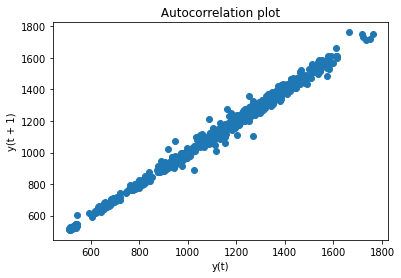

In [15]:
#A lag plot is a special type of scatter plot in which the X-axis represents the dataset with some time units behind or ahead as compared to the Y-axis. 
#exhibits high auto correlation behaviour as the points in the lag plot lie around the diagonal line.
#use lag plot to determine whether acf pacf can be made use of 
plt.figure()
lag_plot(df_1D['close'], lag=1)
plt.title(' Autocorrelation plot ')
plt.show()

the autocorrelation is positive hence we consider the AR term for ARIMA model


In [16]:
import statsmodels.api as sm
def PerTimeData(df, tf):
    df = df.dropna()
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    sm.graphics.tsa.plot_acf(df['close'], lags=40, ax=ax[0])
    sm.graphics.tsa.plot_pacf(df['close'], lags=40, ax=ax[1])
    x = "Closin_"+ str(tf)
    plt.suptitle(x)


/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


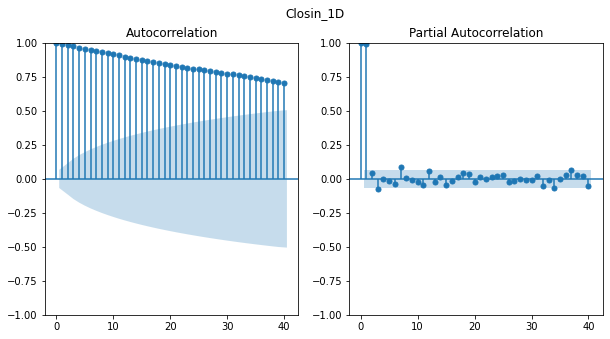

In [17]:
PerTimeData(df_1D, '1D')

Use AR terms in the model when the
ACF plots show autocorrelation decaying towards zero
PACF plot cuts off quickly towards zero
ACF of a stationary series shows positive at lag-1

Use MA terms in the model when the model is
Negatively Autocorrelated at Lag — 1
ACF that drops sharply after a few lags
PACF decreases more gradually

According to the output graph, we use AR terms.

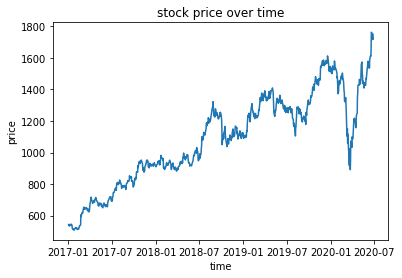

In [18]:
#plotting line plot of price variation 
plt.plot(df_1D["Date"], df_1D["close"])
plt.title("stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

The graph shows that the dataset is not stationary as the mean and standard deviation is not constant, we will further confirm this using Dickey Fuller test 

In [19]:
result = adfuller(df_1D["close"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
  print("\t%s: %.3f" % (key, value))

ADF Statistic: -1.077960
p-value: 0.723781
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


Here, p-value is more than 0.05 this means our null hypothesis will be rejected and we will take this series as non-stationary.

In [20]:
#removing null values
df_1D = df_1D.dropna()

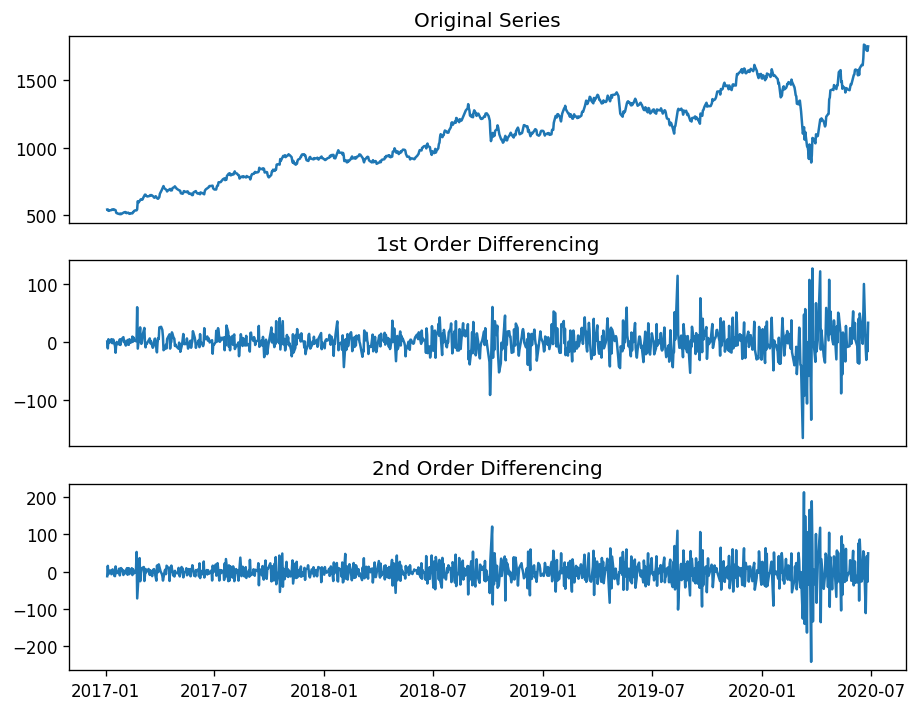

In [21]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df_1D.close); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df_1D.close.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df_1D.close.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

The second differencing is found to have more noise than the first order differencing 

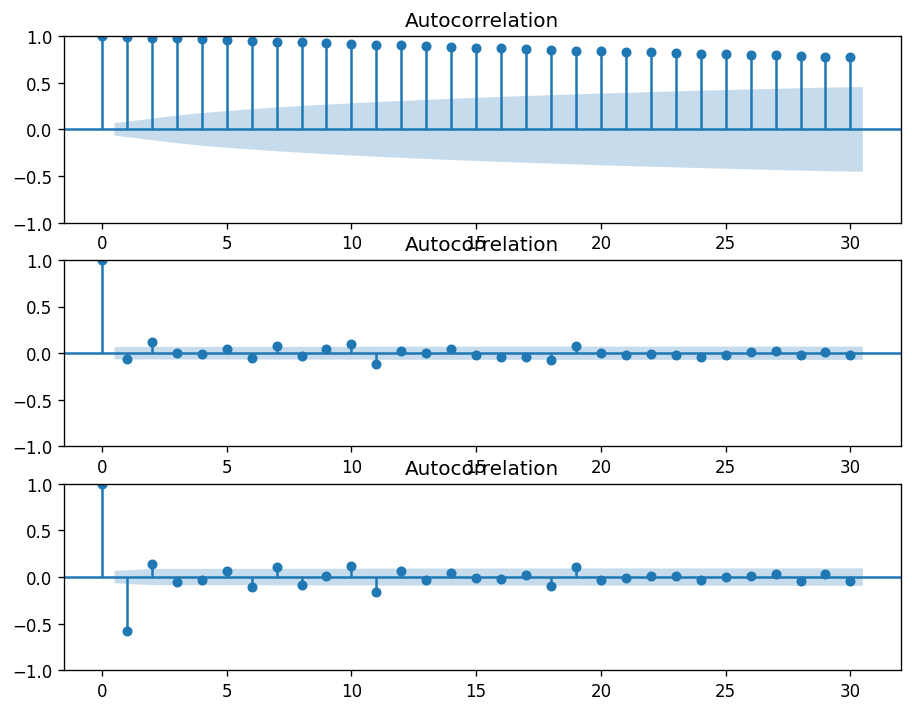

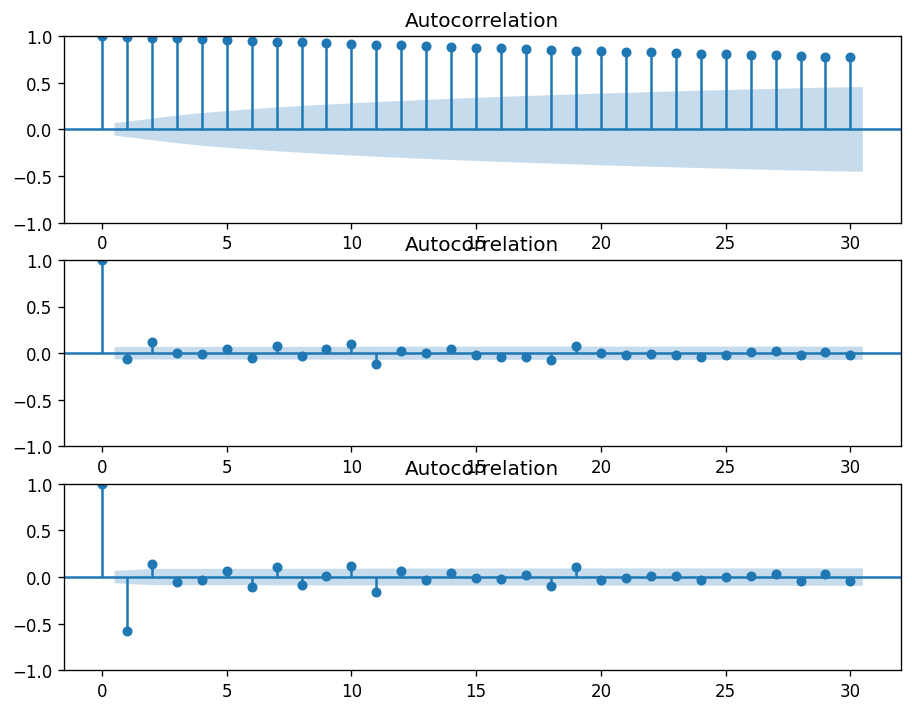

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df_1D.close, ax=ax1)
plot_acf(df_1D.close.diff().dropna(), ax=ax2)
plot_acf(df_1D.close.diff().diff().dropna(), ax=ax3)

Here we can see that in first and second-order differencing the immediate lag has gone on the negative side, representing that in the first and second-order the series has become over the difference. 
So, we take the value of d as 0.


/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


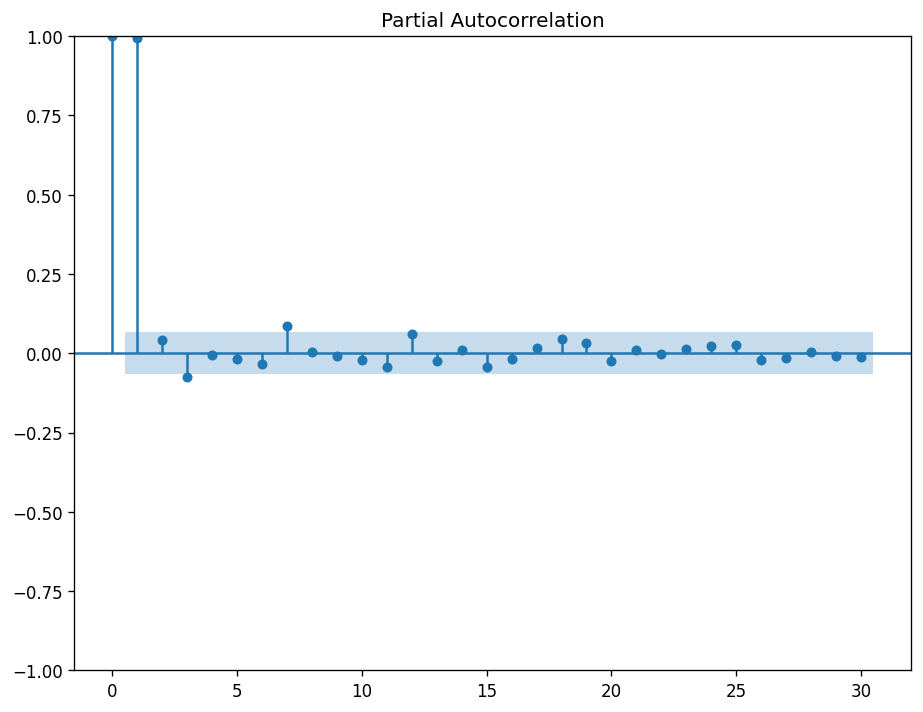

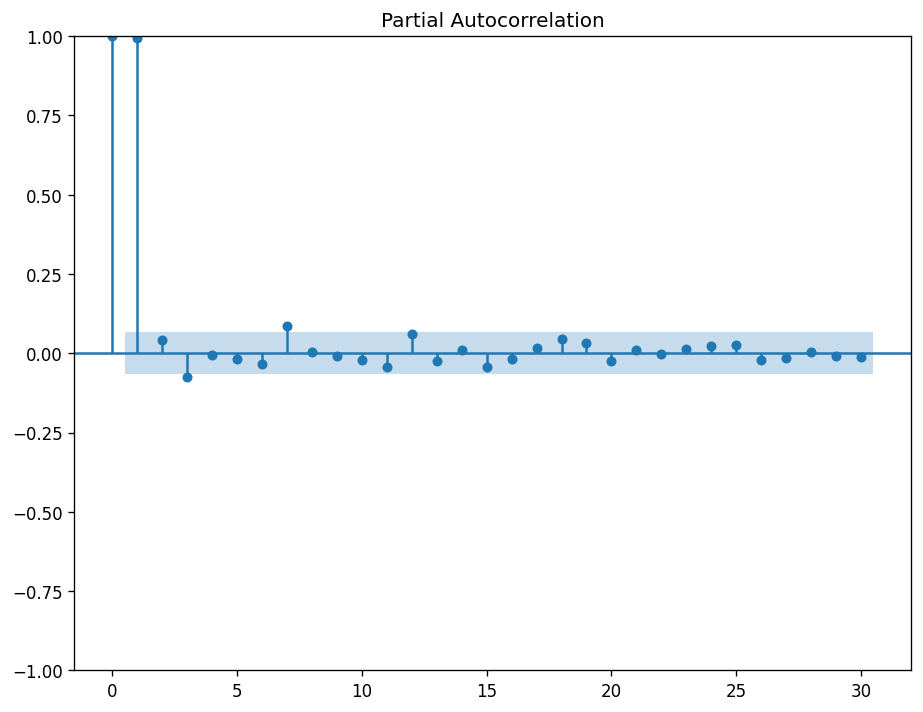

In [23]:
#find the value of p
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_1D.close.dropna())

In [24]:
#splitting data into training and testing data 
train_data, test_data = df_1D[0:int(len(df_1D)*0.7)], df_1D[int(len(df_1D)*0.7):]

In [25]:
len(train_data)

602

In [26]:
# we consider the closing price of stock data for training the model
training_data = train_data['close'].values
test_data = test_data['close'].values

In [27]:
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)

In [28]:
#fiting to ml model and predicting , predicted values stored to model predictions list 
from statsmodels.tsa.arima.model import ARIMA

x = 0
for time_point in range(N_test_observations):
    x = x+1
    y = 100*(x/N_test_observations)
    if(y>90):
        print("at 90")
    elif(y>75):
        print("at 75")
    elif(y>50):
        print("at 50")
    elif(y>25):
        print("at 25")
    elif(y>10):
        print("at 10")
    model = ARIMA(history, order=(3,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 10
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 25
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 50
at 5

we make use of mean squared error as the performance metric. executing the above code for different vakues of p from 1-5, we found that 3 gives the least mean squared error.

In [25]:
mean_absolute_error(test_data, model_predictions)

23.028809471164553

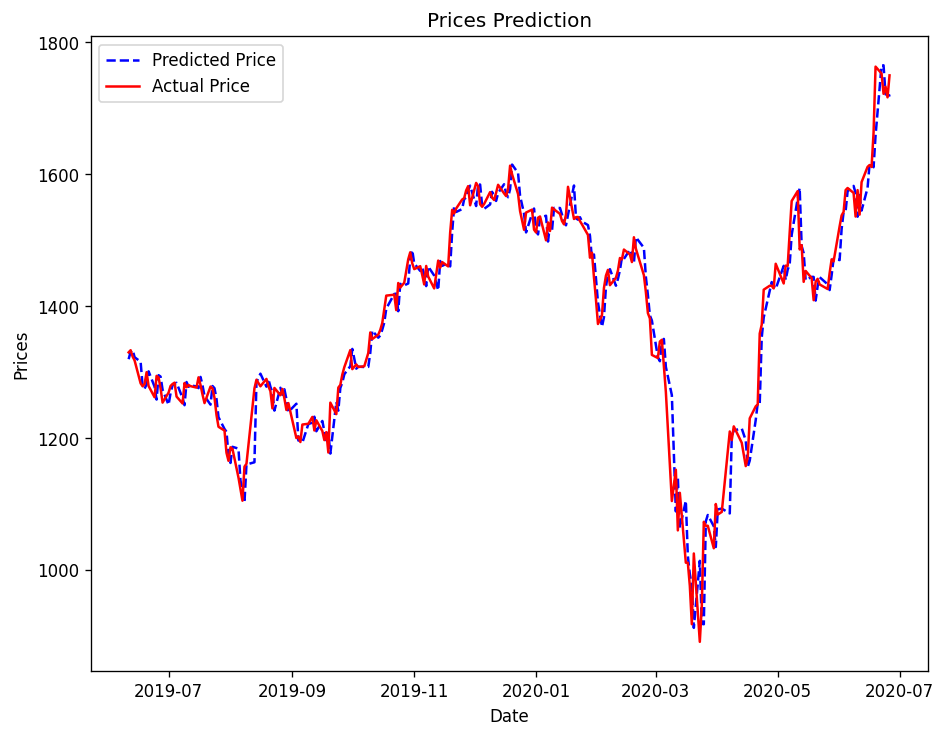

<Figure size 2400x1200 with 0 Axes>

In [26]:
#plotting actual and predicted price 
test_set_range = df_1D[int(len(df_1D)*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.figure(figsize=(20,10))
plt.show()

here the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artificially good.
We Can’t say the performance at this point because we haven’t actually forecasted into the future and compared the forecast with the actual performance.
So, the real validation you need now is the Out-of-Time cross-validation.

In [27]:
columns = ["Name", "ROR_MSE", "ROR_SMAPE","ROR_MAE", "R_MSE", "R_SMAPE","R_MAE", "LOGC_MSE", "LOGC_SMAPE", "LOGC_MAE"]

this function calculates the mean absolute percentage error(MAPE) ,a MAPE lower than 20% is considered good for time series forecasting. This would indicate that on average the forecasts over the whole time period were less than 20% away from the actual values.


In [28]:
def smape_kun(y_true, y_pred):
    return np.mean(  (np.abs(y_pred - y_true) *200/(np.abs(y_pred) + np.abs(y_true))   ))

In [29]:
def printmd(string):
    display(Markdown(string))
printmd('**bold**')

**bold**

In [33]:
def PerTimeData(df, Final, time, Name):

    lcap = pd.DataFrame()
    
    lcap['close'] = df['close'].values
    
    lcap = np.log(lcap).diff() #take log of difference of consequtive data points
    
    
    df = df.dropna()
    lcap = lcap.dropna()
    #add columns lag, rateofreturn and return 
    df['lag'] = df['close'].shift(1)
    df['RateofReturn'] = (df['close']/df['lag'])  -1
    df['Return'] = (df['close']-df['lag'])
    
    df = df.dropna()
    lcap = lcap.dropna()
    
    train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
    
    train_dataL, test_dataL = lcap[0:int(len(lcap)*0.8)], lcap[int(len(lcap)*0.8):]
    #split df and lcap to test train datasets
   #Rate of Return Analysis

    
    #training ARIMA with ROR
    train_ar = train_data['RateofReturn'].values
    test_ar = test_data['RateofReturn'].values
    d = test_data['DateIndex']
    history = [x for x in train_ar]
#     print(type(history))
    predictions = list()
    for t in range(len(test_ar)):
        model = ARIMA(history, order=(5,0,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    error0 = mean_squared_error(test_ar, predictions)
    print('Testing Mean Squared Error: %.3f' % error0)
    error1 = mean_absolute_error(test_ar, predictions)
    print('Testing Mean Absolute Error: %.3f' % error1)
    error2 = smape_kun(test_ar, predictions)
    print('Symmetric mean absolute percentage error: %.3f' % error2)

    
    
    
#     print("\n\n\n Return Analysis")
    ##training ARIMA WITH CLOSING PRICE
    train_ar = train_data['close'].values
    test_ar = test_data['close'].values
    history = [x for x in train_ar]
#     print(type(history))
    predictions = list()
    for t in range(len(test_ar)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    error3 = mean_squared_error(test_ar, predictions)
    print('Testing Mean Squared Error: %.3f' % error3)
    error4 = mean_absolute_error(test_ar, predictions)
    print('Testing Mean Absolute Error: %.3f' % error4)
    error5 = smape_kun(test_ar, predictions)
    print('Symmetric mean absolute percentage error: %.3f' % error5)

    

#training arima with log difference closing price 
    train_ar = train_dataL['close'].values
    test_ar = test_dataL['close'].values
    history = [x for x in train_ar]
#     print(type(history))
    predictions = list()
    for t in range(len(test_ar)):
        model = ARIMA(history, order=(5,0,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    error6 = mean_squared_error(test_ar, predictions)
#Testing Mean Squared Error
    error7 = mean_absolute_error(test_ar, predictions)
#Testing Mean Absolute Error
    error8 = smape_kun(test_ar, predictions)
#Symmetric mean absolute percentage error

    
# columns = ["Name", "ROR_MSE", "ROR_SMAPE","ROR_MAE" "R_MSE", "R_SMAPE","R_MAE", "LOGC_MSE", "LOGC_SMAPE", "LOGC_MAE"]

    
    dict1 = {"Name":Name, "ROR_MSE": error0, "ROR_SMAPE":error2,"ROR_MAE":error1 , "R_MSE" :error3, "R_SMAPE":error5,"R_MAE":error4, "LOGC_MSE":error6 ,  
             "LOGC_SMAPE":error8, "LOGC_MAE":error7 }
    
    Final[time] = (Final[time]).append(dict1, ignore_index = True) 

    
    

In [38]:
def PerTimeData2(df):

    lcap = pd.DataFrame()
    
    lcap['close'] = df['close'].values
    
    lcap = np.log(lcap).diff()
    
    
    df = df.dropna()
    lcap = lcap.dropna()
    
    df['lag'] = df['close'].shift(1)
    df['RateofReturn'] = (df['close']/df['lag'])  -1
    df['Return'] = (df['close']-df['lag'])
    
    df = df.dropna()
    lcap = lcap.dropna()
    
#     train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
    
#     train_dataL, test_dataL = lcap[0:int(len(lcap)*0.8)], lcap[int(len(lcap)*0.8):]


    
    st = min( int(len(df)*0.2), 50)
    st1 = (len(df)) - st
    train_data, test_data = df[0:st1], df[st1:]
    d_index = test_data.index
#     print("Rate of Return Analysis")
#     train_ar = train_data[['RateofReturn']]
#     test_ar = test_data[['RateofReturn']]
    
    
    
    
    
    
    print("Rate of Return Analysis")

    
   
    train_ar = train_data['RateofReturn'].values
    test_ar = test_data['RateofReturn'].values
#     d = test_data['DateIndex']
    history = [x for x in train_ar]
#     print(type(history))
    predictions = list()
    for t in range(len(test_ar)):
        model = ARIMA(history, order=(5,0,2))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    error0 = mean_squared_error(test_ar, predictions)
    print('Testing Mean Squared Error: %.3f' % error0)
    error1 = mean_absolute_error(test_ar, predictions)
    print('Testing Mean Absolute Error: %.3f' % error1)
    error2 = smape_kun(test_ar, predictions)
    print('Symmetric mean absolute percentage error: %.3f' % error2)


    plt.plot(d_index, predictions, color='blue', linestyle='dashed',label='Predicted Rate of Return')
    plt.plot(d_index, test_data['RateofReturn'].values, color='red', label='Actual Return')
    plt.title('Rate of Return Prediction')
    plt.xlabel('Date')
    plt.ylabel('Rate of Return')
    plt.legend()
    plt.figure(figsize=(20,10))
    plt.show()
    
    
    
    
    
    
    
    
#     print("\n\n\n Return Analysis")

    train_ar = train_data['Return'].values
    test_ar = test_data['Return'].values
    history = [x for x in train_ar]
#     print(type(history))
    predictions = list()
    for t in range(len(test_ar)):
        model = ARIMA(history, order=(5,0,2))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    error3 = mean_squared_error(test_ar, predictions)
    print('Testing Mean Squared Error: %.3f' % error3)
    error4 = mean_absolute_error(test_ar, predictions)
    print('Testing Mean Absolute Error: %.3f' % error4)
    error5 = smape_kun(test_ar, predictions)
    print('Symmetric mean absolute percentage error: %.3f' % error5)

    plt.plot(d_index, predictions, color='blue', linestyle='dashed',label='Predicted Rate of Return')
    plt.plot(d_index, test_data['Return'].values, color='red', label='Actual Return')
    plt.title('Return Prediction')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.figure(figsize=(20,10))
    plt.show()
    
    
    print("\n\n\n  Close Price analysis")
    
    
    train_ar = train_data['close'].values
    test_ar = test_data['close'].values
    history = [x for x in train_ar]
#     print(type(history))
    predictions = list()
    for t in range(len(test_ar)):
        model = ARIMA(history, order=(5,1,2))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    error3 = mean_squared_error(test_ar, predictions)
    print('Testing Mean Squared Error: %.3f' % error3)
    error4 = mean_absolute_error(test_ar, predictions)
    print('Testing Mean Absolute Error: %.3f' % error4)
    error5 = smape_kun(test_ar, predictions)
    print('Symmetric mean absolute percentage error: %.3f' % error5)

    plt.plot(d_index, predictions, color='blue', linestyle='dashed',label='Predicted Rate of Return')
    plt.plot(d_index, test_data['close'].values, color='red', label='Actual Return')
    plt.title('Close Prediction')
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.legend()
    plt.figure(figsize=(20,10))
    plt.show()
    
    
    
    

    
    
# #     print("\n\n\n Lost cost diff analysis")

#     train_ar = train_dataL['close'].values
#     test_ar = test_dataL['close'].values
#     history = [x for x in train_ar]
# #     print(type(history))
#     predictions = list()
#     for t in range(len(test_ar)):
#         model = ARIMA(history, order=(5,0,0))
#         model_fit = model.fit(disp=0)
#         output = model_fit.forecast()
#         yhat = output[0]
#         predictions.append(yhat)
#         obs = test_ar[t]
#         history.append(obs)
#     error6 = mean_squared_error(test_ar, predictions)
# #     print('Testing Mean Squared Error: %.3f' % error6)
#     error7 = mean_absolute_error(test_ar, predictions)
# #     print('Testing Mean Absolute Error: %.3f' % error7)
#     error8 = smape_kun(test_ar, predictions)
# #     print('Symmetric mean absolute percentage error: %.3f' % error8)

    
# columns = ["Name", "ROR_MSE", "ROR_SMAPE","ROR_MAE" "R_MSE", "R_SMAPE","R_MAE", "LOGC_MSE", "LOGC_SMAPE", "LOGC_MAE"]

    
#     dict1 = {"Name":Name, "ROR_MSE": error0, "ROR_SMAPE":error2,"ROR_MAE":error1 , "R_MSE" :error3, "R_SMAPE":error5,"R_MAE":error4, "LOGC_MSE":error6 ,  
#              "LOGC_SMAPE":error8, "LOGC_MAE":error7 }
    
#     Final[time] = (Final[time]).append(dict1, ignore_index = True) 

    

Rate of Return Analysis


/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/

Testing Mean Squared Error: 0.001
Testing Mean Absolute Error: 0.018
Symmetric mean absolute percentage error: 156.803


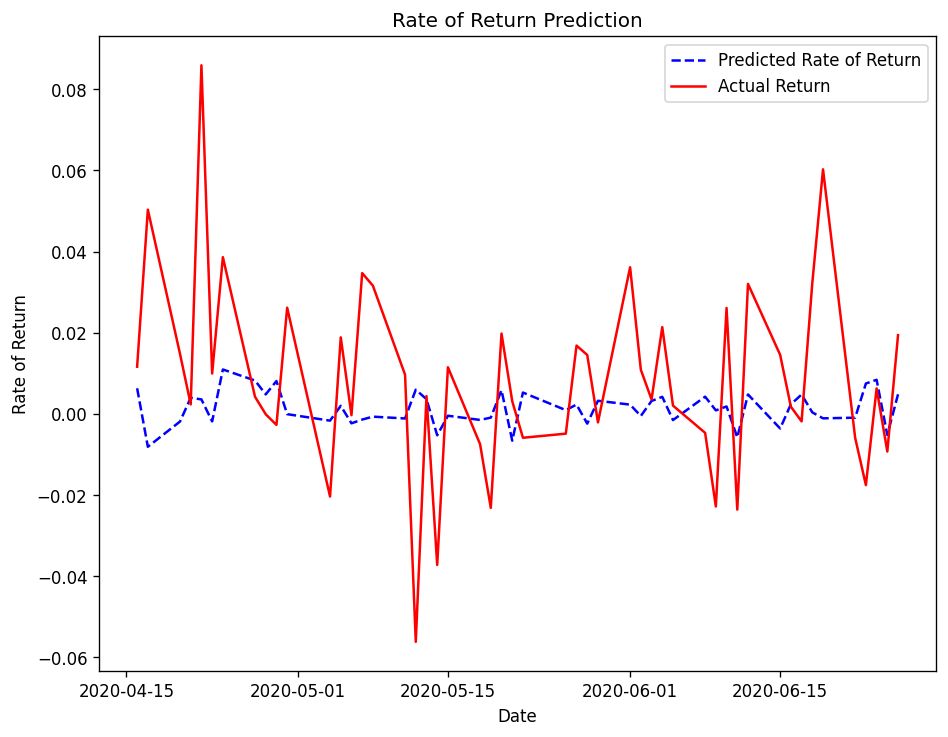

<Figure size 2400x1200 with 0 Axes>

/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/

Testing Mean Squared Error: 1433.457
Testing Mean Absolute Error: 27.496
Symmetric mean absolute percentage error: 156.676


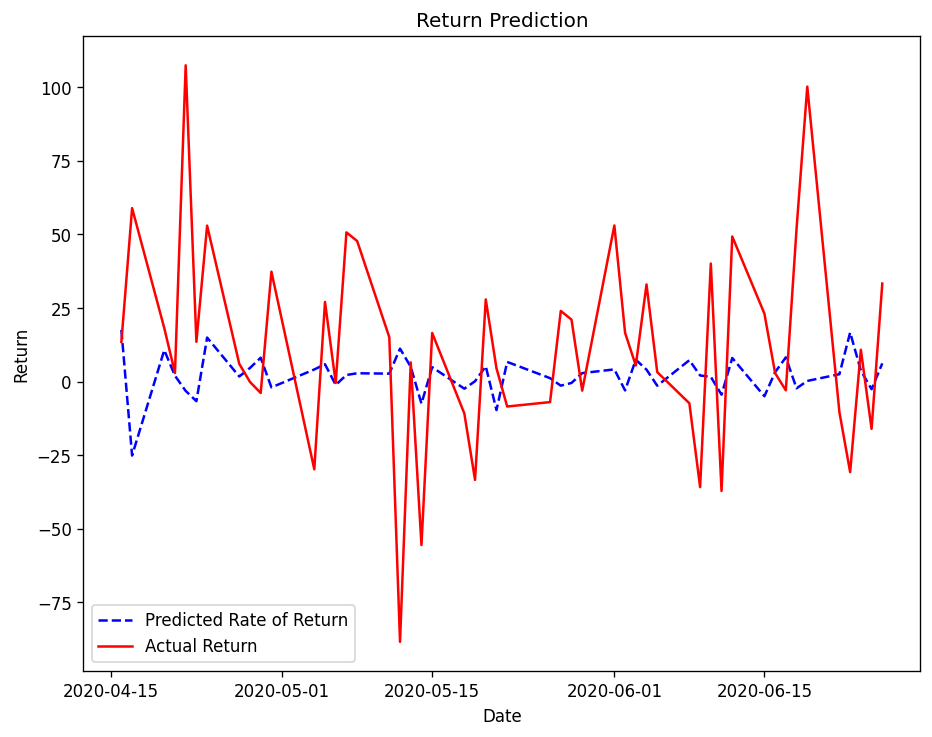

<Figure size 2400x1200 with 0 Axes>




  Close Price analysis


/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/

Testing Mean Squared Error: 1451.254
Testing Mean Absolute Error: 27.694
Symmetric mean absolute percentage error: 1.863


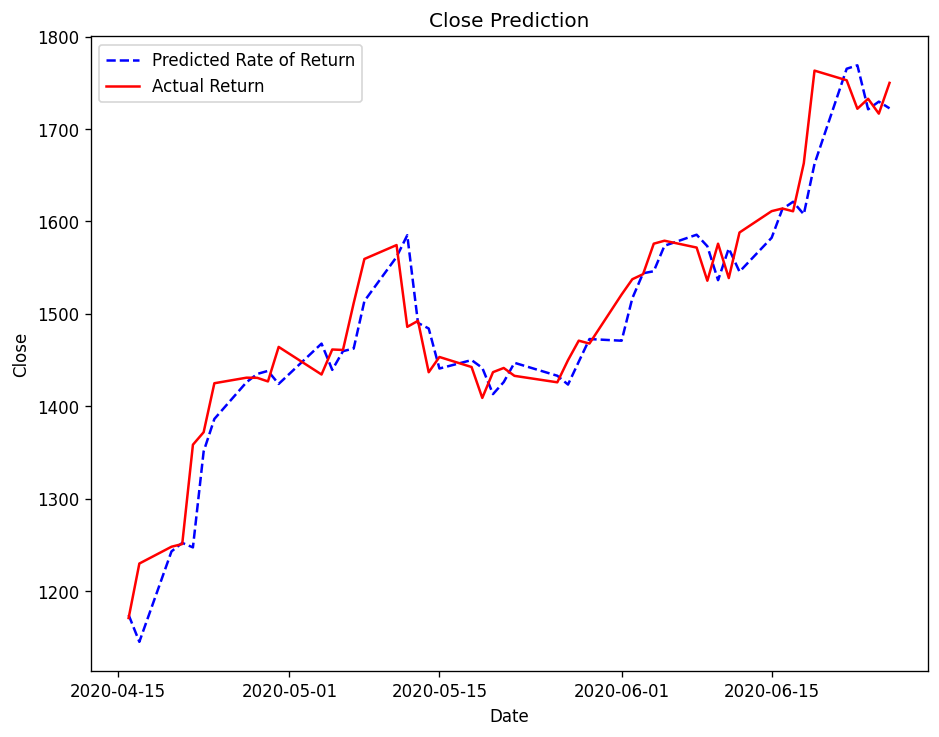

<Figure size 2400x1200 with 0 Axes>

In [39]:
PerTimeData2(df_1D)

In [40]:
# doing analysis for aggregation over 1 week and 1 day using above functions 
def Analyse2(Name):
    df = pd.read_csv(Name)
    
    df = df.dropna()
    
    df['Date'] = pd.to_datetime(df['timestamp'])
    df['DateIndex'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('DateIndex')
    df = df.drop(['timestamp'], axis=1)
    
    

    
#     df_5Min =  FrameChanging(df, '5Min')
#     df_5Min['Date'] = df_5Min.index
    
#     df_10Min = FrameChanging(df, '10Min')
#     df_10Min['Date'] = df_10Min.index
    
#     df_15Min = FrameChanging(df, '15Min')
#     df_15Min['Date'] = df_15Min.index
    
#     df_30Min = FrameChanging(df, '30Min')
#     df_30Min['Date'] = df_30Min.index
    
#     df_60Min = FrameChanging(df, '60Min')
#     df_60Min['Date'] = df_60Min.index
    
    df_1D = FrameChanging(df, '1D')
    df_1D['Date'] = df_1D.index
    
#     df_5D = FrameChanging(df, '5D')
#     df_5D['Date'] = df_5D.index
    
    df_1W = FrameChanging(df, '1W')
    df_1W['Date'] = df_1W.index
    
#     df_10D = FrameChanging(df, '10D')
#     df_10D['Date'] = df_10D.index
    
#     df_15D = FrameChanging(df, '15D')
#     df_15D['Date'] = df_15D.index
    
#     df_1M = FrameChanging(df, '1M')
#     df_1M['Date'] = df_1M.index
    
    
    
    

    
    
    
    
# #     printmd('**1 Minute Data Analysis**')
#     PerTimeData(df, df1, Final, "1_Min", Name, Name2)
    
# #     printmd('**5 Minute Data Analysis**')
#     PerTimeData(df_5Min, df1_5Min, Final, "5_Min",Name, Name2)
    
# #     printmd('**10 Minute Data Analysis**')
#     PerTimeData(df_10Min, df1_10Min, Final, "10_Min",Name, Name2)
    
# #     printmd('**15 Minute Data Analysis**')
#     PerTimeData(df_15Min, df1_15Min, Final, "15_Min",Name, Name2)
    
# #     printmd('**30 Minute Data Analysis**')
#     PerTimeData(df_30Min, df1_30Min, Final, "30_Min",Name, Name2)
    
# #     printmd('**1Hr Data Analysis**')
#     PerTimeData(df_60Min, df1_60Min, Final, "60_Min",Name, Name2)
    
    printmd('**1 Day Data Analysis**')
    PerTimeData2(df_1D)
    
# #     printmd('**5 Day Data Analysis**')
#     PerTimeData(df_5D, df1_5D, Final, "5D",Name, Name2)
    
    printmd('**1 Week Data Analysis**')
    PerTimeData2(df_1W)
    
# #     printmd('**10 Day Data Analysis**')
#     PerTimeData(df_10D, df1_10D, Final, "10D",Name, Name2)
    
# #     printmd('**15 Day Data Analysis**')
#     PerTimeData(df_15D, df1_15D, Final, "15D",Name, Name2)
    
# #     printmd('**1 Month Data Analysis**')
#     PerTimeData(df_1M, df1_1M, Final, "1M",Name, Name2)



**1 Day Data Analysis**

/Users/varshar/Library/Python/3.8/lib/python/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/var/folders/ff/xy6js6tn33v5x_0t8pkqk4y40000gn/T/ipykernel_865/1573294186.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag'] = df['close'].shift(1)
/var/folders/ff/xy6js6tn33v5x_0t8pkqk4y40000gn/T/ipykernel_865/1573294186.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RateofReturn'] = (df['close']/df['lag

Rate of Return Analysis


/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/li

Testing Mean Squared Error: 0.001
Testing Mean Absolute Error: 0.018
Symmetric mean absolute percentage error: 156.803


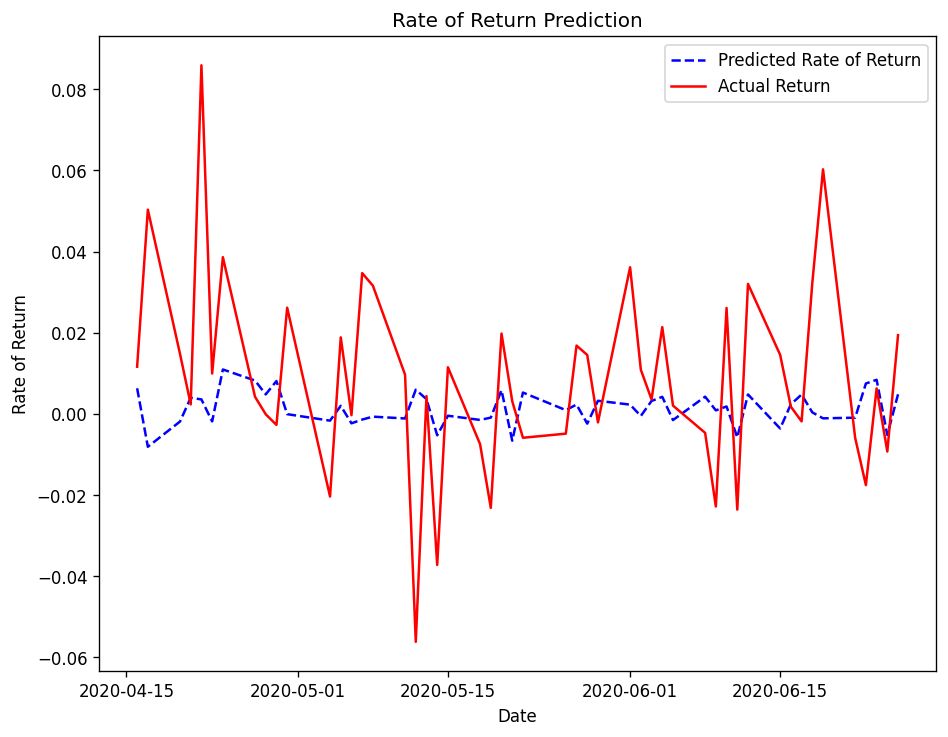

<Figure size 2400x1200 with 0 Axes>

/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/

Testing Mean Squared Error: 1433.457
Testing Mean Absolute Error: 27.496
Symmetric mean absolute percentage error: 156.676


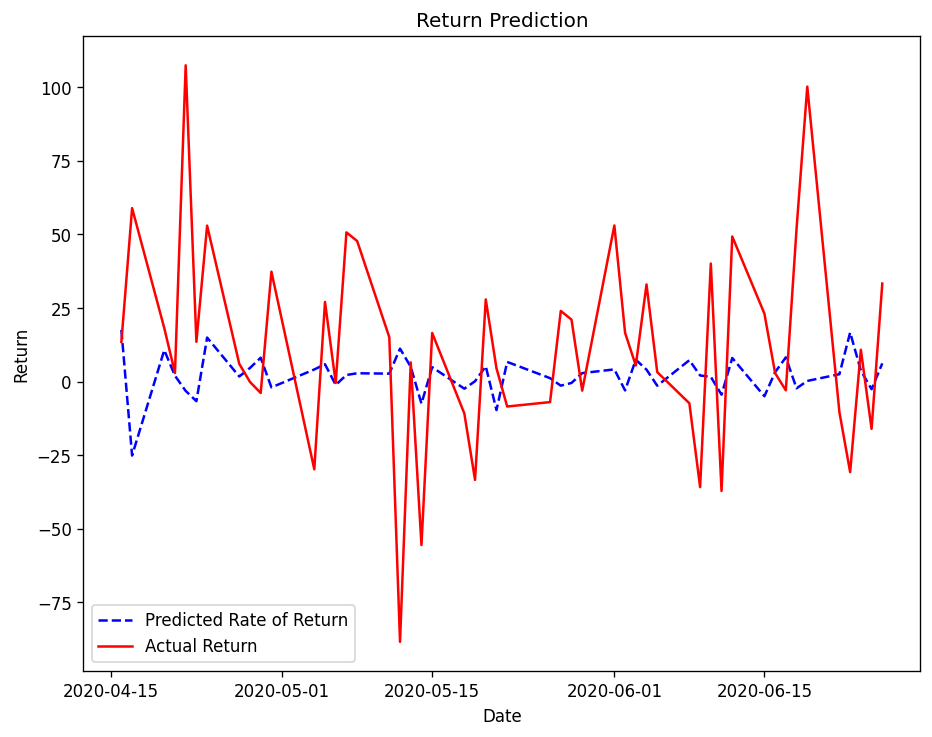

<Figure size 2400x1200 with 0 Axes>




  Close Price analysis


/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/

Testing Mean Squared Error: 1451.254
Testing Mean Absolute Error: 27.694
Symmetric mean absolute percentage error: 1.863


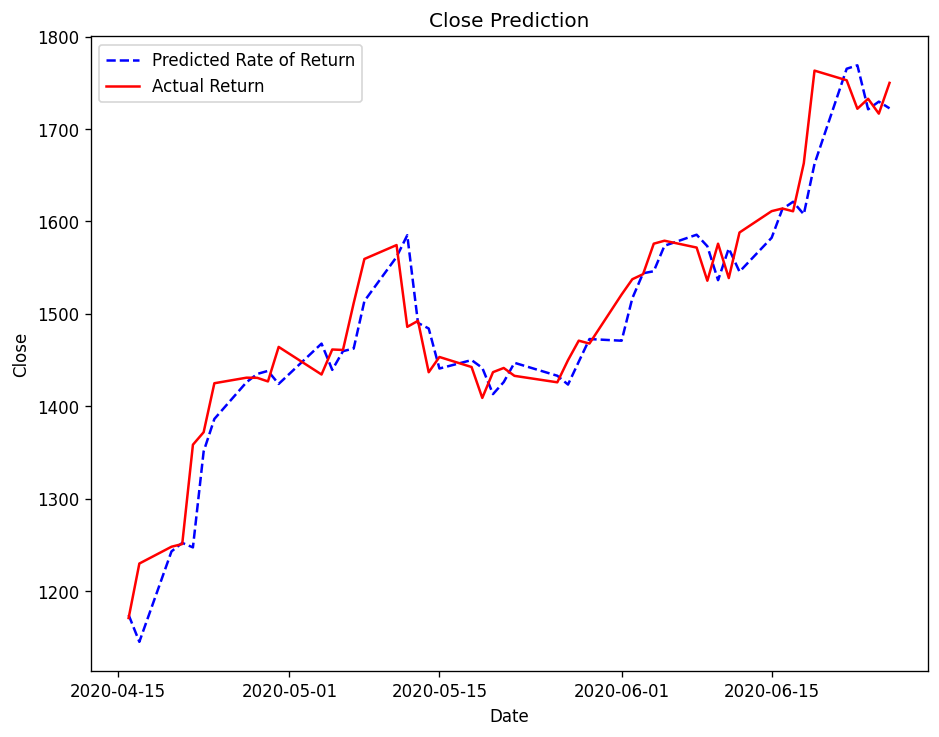

<Figure size 2400x1200 with 0 Axes>

**1 Week Data Analysis**

Rate of Return Analysis


/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/li

Testing Mean Squared Error: 0.004
Testing Mean Absolute Error: 0.045
Symmetric mean absolute percentage error: 160.100


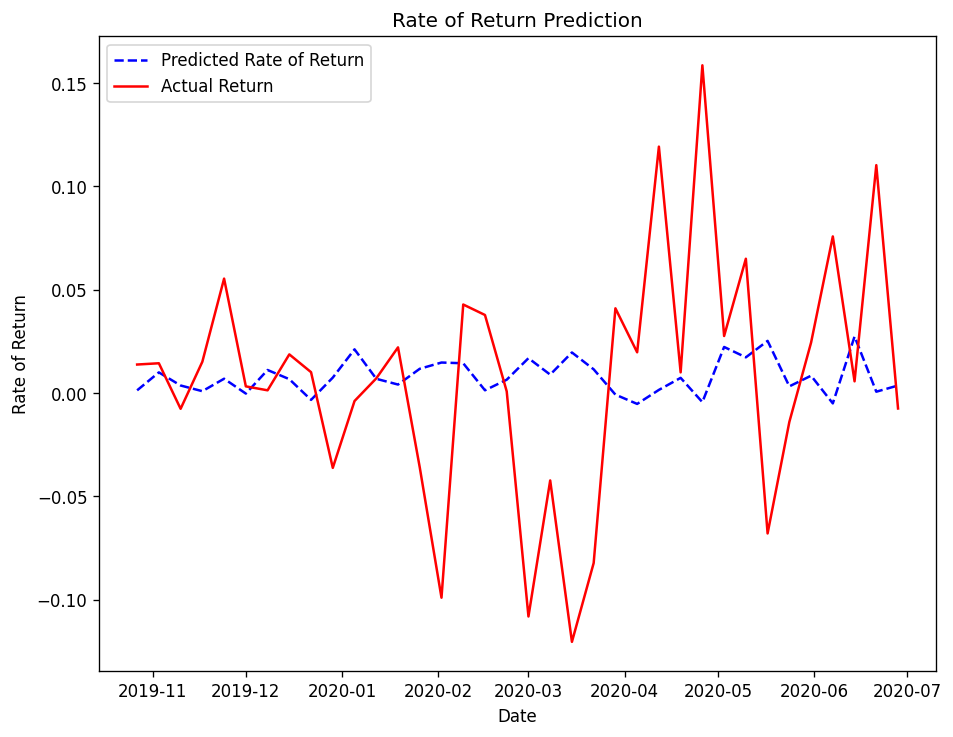

<Figure size 2400x1200 with 0 Axes>

/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/li

Testing Mean Squared Error: 7209.868
Testing Mean Absolute Error: 62.316
Symmetric mean absolute percentage error: 152.726


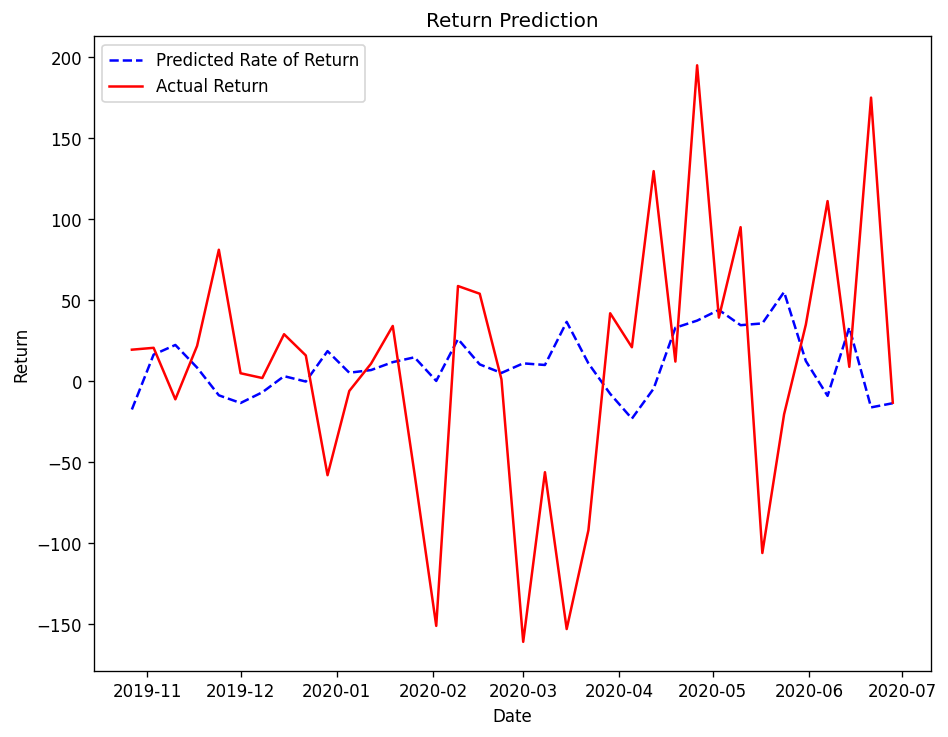

<Figure size 2400x1200 with 0 Axes>




  Close Price analysis


/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/varshar/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/

Testing Mean Squared Error: 7113.063
Testing Mean Absolute Error: 61.504
Symmetric mean absolute percentage error: 4.461


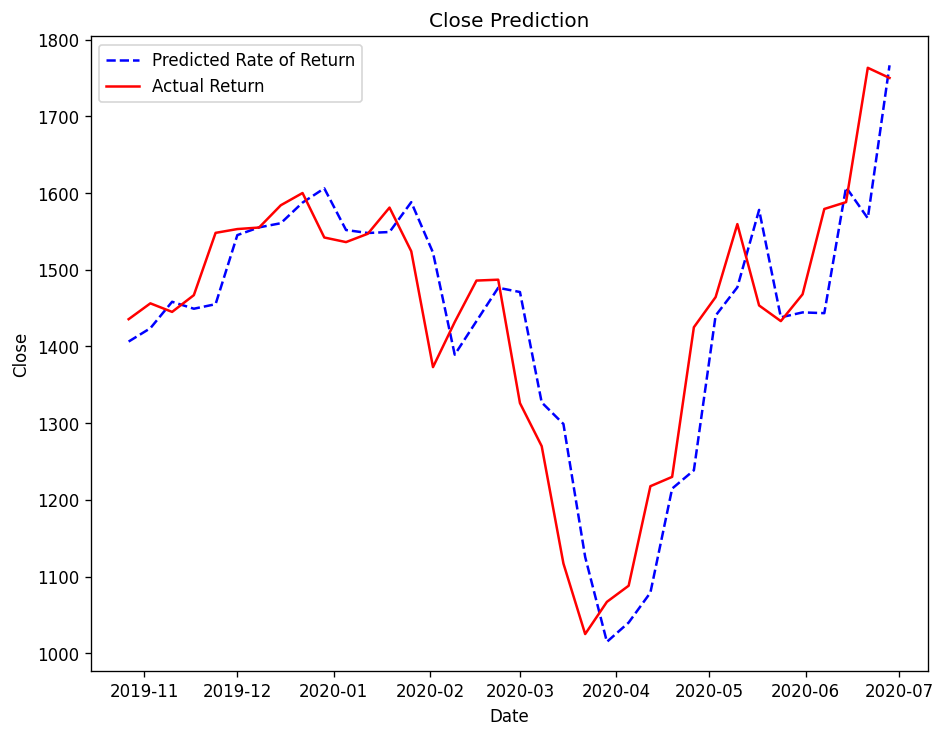

<Figure size 2400x1200 with 0 Axes>

In [41]:
Analyse2("../Data/RELIANCE__EQ__NSE__NSE__MINUTE.csv")

In [44]:
# Analyse2("../nifty.csv")

In [ ]:
df_N_L = pd.read_csv("../nifty.csv")

In [ ]:
df_N_L = df_N_L.dropna()
    
df_N_L['Date'] = pd.to_datetime(df_N_L['timestamp'])
df_N_L['DateIndex'] = pd.to_datetime(df_N_L['timestamp'])
df_N_L = df_N_L.set_index('DateIndex')
df_N_L = df_N_L.drop(['timestamp'], axis=1)

In [ ]:
df_N_L.head()

,timestamp,open,high,low,close,volume,Turnover
0,2014-01-01,6323.80,6327.2,6298.25,6301.65,69567668,2.015360e+10
1,2014-01-02,6301.25,6358.3,6211.30,6221.15,158132556,5.249790e+10
2,2014-01-03,6194.55,6221.7,6171.25,6211.15,139043889,5.369420e+10
3,2014-01-06,6220.85,6224.7,6170.25,6191.45,118344976,4.722670e+10
4,2014-01-07,6203.90,6221.5,6144.75,6162.25,138559000,5.696600e+10


In [ ]:
df_N_L.tail()

,timestamp,open,high,low,close,volume,Turnover
1683,2020-10-26,11937.40,11942.85,11711.70,11767.75,519815905,2.931602e+11
1684,2020-10-27,11807.10,11899.05,11723.00,11889.40,616318543,3.798997e+11
1685,2020-10-28,11922.60,11929.40,11684.85,11729.60,704018608,3.702589e+11
1686,2020-10-29,11633.30,11744.15,11606.45,11670.80,554959844,3.043662e+11
1687,2020-10-30,11678.45,11748.95,11535.45,11642.40,553672805,2.815158e+11


In [ ]:
split_date = pd.datetime(2015,12,31)

df2014 = df_N_L.loc[df_N_L['Date'] <= split_date]
df_R = df_N_L.loc[df_N_L['Date'] > split_date]

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [ ]:
df2014

,open,high,low,close,volume,Turnover,Date
DateIndex,,,,,,,
2014-01-01,6323.80,6327.20,6298.25,6301.65,69567668,2.015360e+10,2014-01-01
2014-01-02,6301.25,6358.30,6211.30,6221.15,158132556,5.249790e+10,2014-01-02
2014-01-03,6194.55,6221.70,6171.25,6211.15,139043889,5.369420e+10,2014-01-03
2014-01-06,6220.85,6224.70,6170.25,6191.45,118344976,4.722670e+10,2014-01-06
2014-01-07,6203.90,6221.50,6144.75,6162.25,138559000,5.696600e+10,2014-01-07
...,...,...,...,...,...,...,...
2015-12-24,7888.75,7888.75,7835.50,7861.05,96374245,3.383990e+10,2015-12-24
2015-12-28,7863.20,7937.20,7863.00,7925.15,126737811,5.755480e+10,2015-12-28
2015-12-29,7929.20,7942.15,7902.75,7928.95,116535971,4.950360e+10,2015-12-29


In [ ]:
split_date = pd.datetime(2017,12,31)

df2016 = df_R.loc[df_R['Date'] <= split_date]
df_R = df_R.loc[df_R['Date'] > split_date]

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [ ]:
df2016

,open,high,low,close,volume,Turnover,Date
DateIndex,,,,,,,
2016-01-01,7938.45,7972.55,7909.80,7963.20,64843836,2.613910e+10,2016-01-01
2016-01-04,7924.55,7937.55,7781.10,7791.30,138864905,5.897080e+10,2016-01-04
2016-01-05,7828.40,7831.20,7763.25,7784.65,149672973,5.948510e+10,2016-01-05
2016-01-06,7788.05,7800.95,7721.20,7741.00,151715828,6.722170e+10,2016-01-06
2016-01-07,7673.35,7674.95,7556.60,7568.30,194732861,7.803210e+10,2016-01-07
...,...,...,...,...,...,...,...
2017-12-22,10457.30,10501.10,10448.25,10493.00,143119167,8.755320e+10,2017-12-22
2017-12-26,10512.30,10545.45,10477.95,10531.50,160417384,9.043770e+10,2017-12-26
2017-12-27,10531.05,10552.40,10469.25,10490.75,170307122,9.077600e+10,2017-12-27


In [ ]:
df_R 

,open,high,low,close,volume,Turnover,Date
DateIndex,,,,,,,
2018-01-01,10531.70,10537.85,10423.10,10435.55,134532090,7.546560e+10,2018-01-01
2018-01-02,10477.55,10495.20,10404.65,10442.20,158092430,8.665470e+10,2018-01-02
2018-01-03,10482.65,10503.60,10429.55,10443.20,172516859,9.541600e+10,2018-01-03
2018-01-04,10469.40,10513.00,10441.45,10504.80,180257392,9.561950e+10,2018-01-04
2018-01-05,10534.25,10566.10,10520.10,10558.85,186469717,1.030622e+11,2018-01-05
...,...,...,...,...,...,...,...
2020-10-26,11937.40,11942.85,11711.70,11767.75,519815905,2.931602e+11,2020-10-26
2020-10-27,11807.10,11899.05,11723.00,11889.40,616318543,3.798997e+11,2020-10-27
2020-10-28,11922.60,11929.40,11684.85,11729.60,704018608,3.702589e+11,2020-10-28


In [ ]:
split_date = pd.datetime(2019,12,31)

df2018 = df_R.loc[df_R['Date'] <= split_date]
df_R = df_R.loc[df_R['Date'] > split_date]

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [ ]:
df2018

,open,high,low,close,volume,Turnover,Date
DateIndex,,,,,,,
2018-01-01,10531.70,10537.85,10423.10,10435.55,134532090,7.546560e+10,2018-01-01
2018-01-02,10477.55,10495.20,10404.65,10442.20,158092430,8.665470e+10,2018-01-02
2018-01-03,10482.65,10503.60,10429.55,10443.20,172516859,9.541600e+10,2018-01-03
2018-01-04,10469.40,10513.00,10441.45,10504.80,180257392,9.561950e+10,2018-01-04
2018-01-05,10534.25,10566.10,10520.10,10558.85,186469717,1.030622e+11,2018-01-05
...,...,...,...,...,...,...,...
2019-12-24,12269.25,12283.70,12202.10,12214.55,470290298,1.386456e+11,2019-12-24
2019-12-26,12211.85,12221.55,12118.85,12126.55,520326632,1.636231e+11,2019-12-26
2019-12-27,12172.90,12258.45,12157.90,12245.80,383788556,1.367620e+11,2019-12-27


In [ ]:
df_R

,open,high,low,close,volume,Turnover,Date
DateIndex,,,,,,,
2020-01-01,12202.15,12222.20,12165.30,12182.50,304078039,1.044568e+11,2020-01-01
2020-01-02,12198.55,12289.90,12195.25,12282.20,407697594,1.525655e+11,2020-01-02
2020-01-03,12261.10,12265.60,12191.35,12226.65,428770054,1.682727e+11,2020-01-03
2020-01-06,12170.60,12179.10,11974.20,11993.05,396501419,1.686922e+11,2020-01-06
2020-01-07,12079.10,12152.15,12005.35,12052.95,447818617,1.779768e+11,2020-01-07
...,...,...,...,...,...,...,...
2020-10-26,11937.40,11942.85,11711.70,11767.75,519815905,2.931602e+11,2020-10-26
2020-10-27,11807.10,11899.05,11723.00,11889.40,616318543,3.798997e+11,2020-10-27
2020-10-28,11922.60,11929.40,11684.85,11729.60,704018608,3.702589e+11,2020-10-28


Rate of Return Analysis


C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\a

Testing Mean Squared Error: 0.000
Testing Mean Absolute Error: 0.006
Symmetric mean absolute percentage error: 159.032


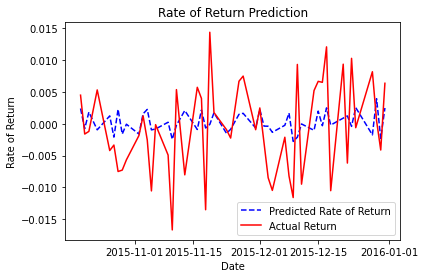

<Figure size 1440x720 with 0 Axes>

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:

Testing Mean Squared Error: 3503.915
Testing Mean Absolute Error: 49.141
Symmetric mean absolute percentage error: 166.281


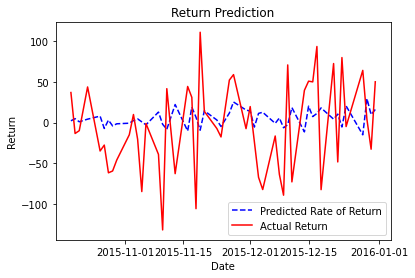

<Figure size 1440x720 with 0 Axes>




  Close Price analysis


C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Chec

LinAlgError: SVD did not converge

In [ ]:
PerTimeData2(df2014)

Rate of Return Analysis


C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\a

Testing Mean Squared Error: 0.000
Testing Mean Absolute Error: 0.005
Symmetric mean absolute percentage error: 160.699


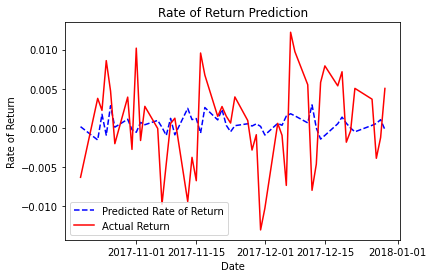

<Figure size 1440x720 with 0 Axes>

Testing Mean Squared Error: 3547.814
Testing Mean Absolute Error: 48.153
Symmetric mean absolute percentage error: 163.344


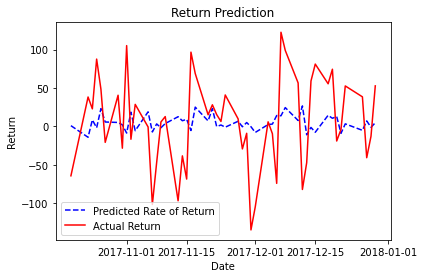

<Figure size 1440x720 with 0 Axes>




  Close Price analysis
Testing Mean Squared Error: 3505.722
Testing Mean Absolute Error: 47.712
Symmetric mean absolute percentage error: 1.294


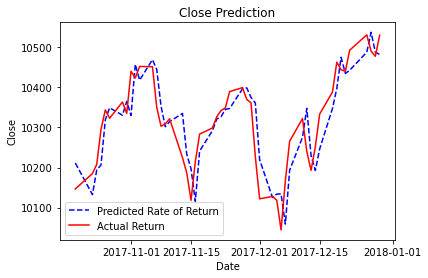

<Figure size 1440x720 with 0 Axes>

In [ ]:
PerTimeData2(df2016)

Rate of Return Analysis


C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


Testing Mean Squared Error: 0.000
Testing Mean Absolute Error: 0.004
Symmetric mean absolute percentage error: 154.235


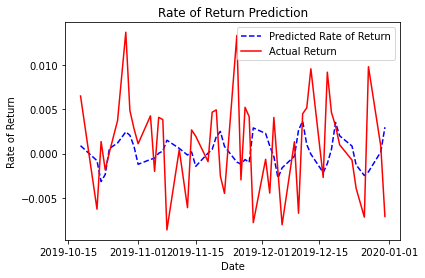

<Figure size 1440x720 with 0 Axes>

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', 

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', 

Testing Mean Squared Error: 4554.164
Testing Mean Absolute Error: 53.569
Symmetric mean absolute percentage error: 157.725


C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


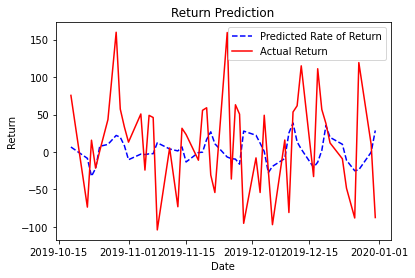

<Figure size 1440x720 with 0 Axes>




  Close Price analysis


C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', 

Testing Mean Squared Error: 4555.106
Testing Mean Absolute Error: 53.579
Symmetric mean absolute percentage error: 1.745


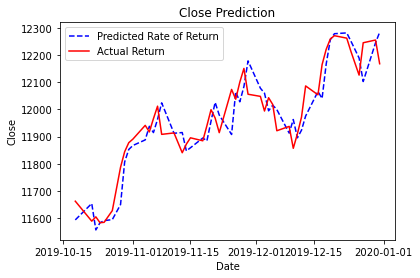

<Figure size 1440x720 with 0 Axes>

In [ ]:
PerTimeData2(df2018)

Rate of Return Analysis
Testing Mean Squared Error: 0.000
Testing Mean Absolute Error: 0.009
Symmetric mean absolute percentage error: 151.591


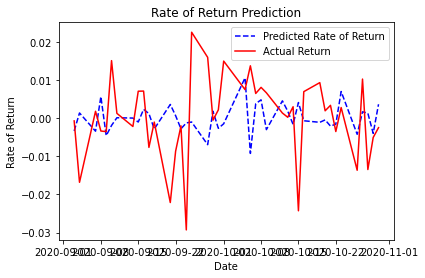

<Figure size 1440x720 with 0 Axes>

Testing Mean Squared Error: 18925.368
Testing Mean Absolute Error: 102.907
Symmetric mean absolute percentage error: 151.223


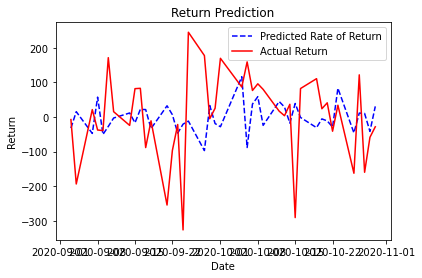

<Figure size 1440x720 with 0 Axes>




  Close Price analysis
Testing Mean Squared Error: 18901.829
Testing Mean Absolute Error: 102.824
Symmetric mean absolute percentage error: 2.928


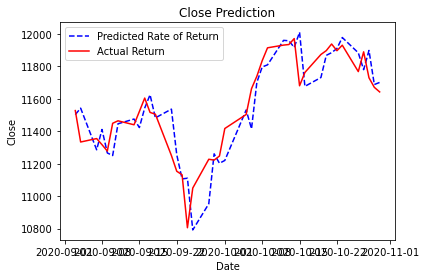

<Figure size 1440x720 with 0 Axes>

In [ ]:
PerTimeData2(df_R)

In [ ]:
def Analyse(Name, Final):
    df = pd.read_csv(Name)
    
    df = df.dropna()
    
    df['Date'] = pd.to_datetime(df['timestamp'])
    df['DateIndex'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('DateIndex')
    df = df.drop(['timestamp'], axis=1)
    
    

    
#     df_5Min =  FrameChanging(df, '5Min')
#     df_5Min['Date'] = df_5Min.index
    
#     df_10Min = FrameChanging(df, '10Min')
#     df_10Min['Date'] = df_10Min.index
    
#     df_15Min = FrameChanging(df, '15Min')
#     df_15Min['Date'] = df_15Min.index
    
#     df_30Min = FrameChanging(df, '30Min')
#     df_30Min['Date'] = df_30Min.index
    
#     df_60Min = FrameChanging(df, '60Min')
#     df_60Min['Date'] = df_60Min.index
    
    df_1D = FrameChanging(df, '1D')
    df_1D['Date'] = df_1D.index
    
#     df_5D = FrameChanging(df, '5D')
#     df_5D['Date'] = df_5D.index
    
    df_1W = FrameChanging(df, '1W')
    df_1W['Date'] = df_1W.index
    
#     df_10D = FrameChanging(df, '10D')
#     df_10D['Date'] = df_10D.index
    
#     df_15D = FrameChanging(df, '15D')
#     df_15D['Date'] = df_15D.index
    
#     df_1M = FrameChanging(df, '1M')
#     df_1M['Date'] = df_1M.index
    
    
    
    

    
    
    
    
# #     printmd('**1 Minute Data Analysis**')
#     PerTimeData(df, df1, Final, "1_Min", Name, Name2)
    
# #     printmd('**5 Minute Data Analysis**')
#     PerTimeData(df_5Min, df1_5Min, Final, "5_Min",Name, Name2)
    
# #     printmd('**10 Minute Data Analysis**')
#     PerTimeData(df_10Min, df1_10Min, Final, "10_Min",Name, Name2)
    
# #     printmd('**15 Minute Data Analysis**')
#     PerTimeData(df_15Min, df1_15Min, Final, "15_Min",Name, Name2)
    
# #     printmd('**30 Minute Data Analysis**')
#     PerTimeData(df_30Min, df1_30Min, Final, "30_Min",Name, Name2)
    
# #     printmd('**1Hr Data Analysis**')
#     PerTimeData(df_60Min, df1_60Min, Final, "60_Min",Name, Name2)
    
    printmd('**1 Day Data Analysis**')
    PerTimeData(df_1D, Final, "1D",Name)
    
# #     printmd('**5 Day Data Analysis**')
#     PerTimeData(df_5D, df1_5D, Final, "5D",Name, Name2)
    
    printmd('**1 Week Data Analysis**')
    PerTimeData(df_1W, Final, "1W",Name)
    
# #     printmd('**10 Day Data Analysis**')
#     PerTimeData(df_10D, df1_10D, Final, "10D",Name, Name2)
    
# #     printmd('**15 Day Data Analysis**')
#     PerTimeData(df_15D, df1_15D, Final, "15D",Name, Name2)
    
# #     printmd('**1 Month Data Analysis**')
#     PerTimeData(df_1M, df1_1M, Final, "1M",Name, Name2)



In [ ]:
# Final = {}
# Final["1_Min"] = pd.DataFrame(columns=columns)
# Final["5_Min"] = pd.DataFrame(columns=columns)
# Final["10_Min"] = pd.DataFrame(columns=columns)
# Final["15_Min"] = pd.DataFrame(columns=columns)
# Final["30_Min"] = pd.DataFrame(columns=columns)
# Final["60_Min"] = pd.DataFrame(columns=columns)
# Final["1D"] = pd.DataFrame(columns=columns)
# Final["5D"] = pd.DataFrame(columns=columns)
# Final["1W"] = pd.DataFrame(columns=columns)
# Final["10D"] = pd.DataFrame(columns=columns)
# Final["15D"] = pd.DataFrame(columns=columns)
# Final["1M"] = pd.DataFrame(columns=columns)

In [ ]:
# import glob
# l =(glob.glob("../Data/*.csv"))
# print(l[1])

In [ ]:
# l

NameError: name 'l' is not defined

In [ ]:
# Num = len(l)

In [ ]:
# for i in range(0,Num):
#     print(i)
#     try:
#         Analyse(l[i], Final)
#     except:
#         print(i , " failed")

# Final["1_Min"].to_csv('file1Min.csv')
# Final["5_Min"].to_csv('file5Min.csv')
# Final["10_Min"].to_csv('file10Min.csv')
# Final["15_Min"].to_csv('file15Min.csv')
# Final["30_Min"].to_csv('file30Min.csv')
# # Final["60_Min"].to_csv('file60Min.csv')
# Final["1D"].to_csv('file1D.csv')
# # Final["5D"].to_csv('file5D.csv')
# Final["1W"].to_csv('file1W.csv')
# Final["10D"].to_csv('file10D.csv')
# Final["15D"].to_csv('file15D.csv')
# Final["1M"].to_csv('file1M.csv')

In [ ]:
Analyse("../Data/RELIANCE__EQ__NSE__NSE__MINUTE.csv", Final)

NameError: name 'Final' is not defined

In [ ]:
Analyse("../Data/ADANIPOWER__EQ__NSE__NSE__MINUTE.csv", Final)

In [ ]:
Final["1D"].head()

In [ ]:
df_nif = pd.read_csv("../Data/NIFTY_50__EQ__INDICES__NSE__MINUTE.csv")
    
df_nif = df_nif.dropna()
    
df_nif['Date'] = pd.to_datetime(df_nif['timestamp'])
df_nif['DateIndex'] = pd.to_datetime(df_nif['timestamp'])
df_nif = df_nif.set_index('DateIndex')
df_nif = df_nif.drop(['timestamp'], axis=1)

In [ ]:
df_nif = FrameChanging(df_nif, '1D')
df_nif['Date'] = df_nif.index

In [ ]:
df_nif.shape

(1272, 6)

In [ ]:
df_nif.head()

,open,close,low,high,volume,Date
DateIndex,,,,,,
2017-01-02 00:00:00+05:30,8210.10,8179.20,8134.30,8211.70,0.0,2017-01-02 00:00:00+05:30
2017-01-03 00:00:00+05:30,8195.25,8189.05,8148.65,8219.00,0.0,2017-01-03 00:00:00+05:30
2017-01-04 00:00:00+05:30,8200.80,8196.35,8180.95,8218.45,0.0,2017-01-04 00:00:00+05:30
2017-01-05 00:00:00+05:30,8226.65,8270.50,8223.90,8282.55,0.0,2017-01-05 00:00:00+05:30
2017-01-06 00:00:00+05:30,8283.00,8248.20,8233.45,8306.50,0.0,2017-01-06 00:00:00+05:30


Testing Mean Squared Error: 40987.076
Testing Mean Absolute Error: 164.144
Symmetric mean absolute percentage error: 160.416


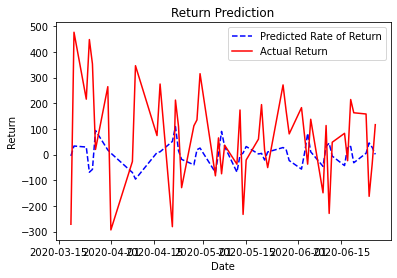

<Figure size 1440x720 with 0 Axes>




  Close Price analysis
Testing Mean Squared Error: 83283.825
Testing Mean Absolute Error: 213.176
Symmetric mean absolute percentage error: 7.683


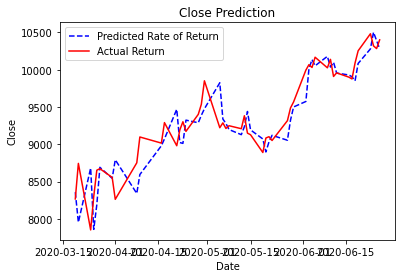

<Figure size 1440x720 with 0 Axes>

In [ ]:
# lcap = pd.DataFrame()
    
# lcap['close'] = df['close'].values
    
# lcap = np.log(lcap).diff()
    
    
# df = df.dropna()
# lcap = lcap.dropna()
    
df_nif['lag'] = df_nif['close'].shift(1)
df_nif['RateofReturn'] = (df_nif['close']/df_nif['lag'])  -1
df_nif['Return'] = (df_nif['close']-df_nif['lag'])
    
df_nif = df_nif.dropna()
# lcap = lcap.dropna()
    
#     train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
    
#     train_dataL, test_dataL = lcap[0:int(len(lcap)*0.8)], lcap[int(len(lcap)*0.8):]


    
st = min( int(len(df_nif)*0.2), 50)
st1 = (len(df_nif)) - st
train_data, test_data = df_nif[0:st1], df_nif[st1:]
d_index = test_data.index
#     print("Rate of Return Analysis")
#     train_ar = train_data[['RateofReturn']]
#     test_ar = test_data[['RateofReturn']]
    
    
    
    
    
    
#     print("Rate of Return Analysis")

    
   
#     train_ar = train_data['RateofReturn'].values
#     test_ar = test_data['RateofReturn'].values
# #     d = test_data['DateIndex']
#     history = [x for x in train_ar]
# #     print(type(history))
#     predictions = list()
#     for t in range(len(test_ar)):
#         model = ARIMA(history, order=(5,0,2))
#         model_fit = model.fit(disp=0)
#         output = model_fit.forecast()
#         yhat = output[0]
#         predictions.append(yhat)
#         obs = test_ar[t]
#         history.append(obs)
#     error0 = mean_squared_error(test_ar, predictions)
#     print('Testing Mean Squared Error: %.3f' % error0)
#     error1 = mean_absolute_error(test_ar, predictions)
#     print('Testing Mean Absolute Error: %.3f' % error1)
#     error2 = smape_kun(test_ar, predictions)
#     print('Symmetric mean absolute percentage error: %.3f' % error2)


#     plt.plot(d_index, predictions, color='blue', linestyle='dashed',label='Predicted Rate of Return')
#     plt.plot(d_index, test_data['RateofReturn'].values, color='red', label='Actual Return')
#     plt.title('Rate of Return Prediction')
#     plt.xlabel('Date')
#     plt.ylabel('Rate of Return')
#     plt.legend()
#     plt.figure(figsize=(20,10))
#     plt.show()
    
    
    
    
    
    
    
    
#     print("\n\n\n Return Analysis")

train_ar = train_data['Return'].values
test_ar = test_data['Return'].values
history = [x for x in train_ar]
#     print(type(history))
predictions_R = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,0,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions_R.append(yhat)
    obs = test_ar[t]
    history.append(obs)
error3 = mean_squared_error(test_ar, predictions_R)
print('Testing Mean Squared Error: %.3f' % error3)
error4 = mean_absolute_error(test_ar, predictions_R)
print('Testing Mean Absolute Error: %.3f' % error4)
error5 = smape_kun(test_ar, predictions_R)
print('Symmetric mean absolute percentage error: %.3f' % error5)

plt.plot(d_index, predictions_R, color='blue', linestyle='dashed',label='Predicted Rate of Return')
plt.plot(d_index, test_data['Return'].values, color='red', label='Actual Return')
plt.title('Return Prediction')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.figure(figsize=(20,10))
plt.show()
    
    
print("\n\n\n  Close Price analysis")
 
    
train_ar = train_data['close'].values
test_ar = test_data['close'].values
history = [x for x in train_ar]
#     print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
error3 = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error3)
error4 = mean_absolute_error(test_ar, predictions)
print('Testing Mean Absolute Error: %.3f' % error4)
error5 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error5)

plt.plot(d_index, predictions, color='blue', linestyle='dashed',label='Predicted Rate of Return')
plt.plot(d_index, test_data['close'].values, color='red', label='Actual Return')
plt.title('Close Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.figure(figsize=(20,10))
plt.show()

In [ ]:
predictions_R

[array([-5.20329142]),
 array([33.27161017]),
 array([29.33842726]),
 array([-68.72361977]),
 array([-57.77355001]),
 array([93.73752141]),
 array([17.92799142]),
 array([5.62286557]),
 array([-70.06795863]),
 array([-95.59436967]),
 array([7.74850221]),
 array([10.69107802]),
 array([51.08069701]),
 array([108.93224228]),
 array([14.96071908]),
 array([-18.70454191]),
 array([-39.96521048]),
 array([18.86721445]),
 array([25.29117908]),
 array([-69.57720089]),
 array([5.12863638]),
 array([90.23790132]),
 array([31.37602304]),
 array([-68.69535497]),
 array([-2.69927559]),
 array([5.94604159]),
 array([31.39337581]),
 array([2.37168061]),
 array([4.62390115]),
 array([-21.3742902]),
 array([10.06893914]),
 array([27.3606492]),
 array([19.63499961]),
 array([-23.34937387]),
 array([-56.65538676]),
 array([6.42311506]),
 array([82.53515325]),
 array([10.68792249]),
 array([-45.98097298]),
 array([31.48029331]),
 array([44.35890021]),
 array([-6.08887626]),
 array([-42.94811674]),
 array

In [ ]:
predictions

[array([8358.29533079]),
 array([7953.62759747]),
 array([8682.17249024]),
 array([7859.57652913]),
 array([8190.94708922]),
 array([8691.77242004]),
 array([8544.30002106]),
 array([8793.27325612]),
 array([8341.17682766]),
 array([8595.12673873]),
 array([8980.99242277]),
 array([9072.39044583]),
 array([9469.970138]),
 array([9023.48052852]),
 array([9012.77608395]),
 array([9324.41013204]),
 array([9289.23958029]),
 array([9389.74690027]),
 array([9476.52767489]),
 array([9825.72989121]),
 array([9339.68580382]),
 array([9279.87400738]),
 array([9198.39524737]),
 array([9129.71706663]),
 array([9236.26843951]),
 array([9440.51174767]),
 array([9193.67613942]),
 array([9072.03032754]),
 array([8897.90287803]),
 array([9032.81782932]),
 array([9120.89347755]),
 array([9054.92566522]),
 array([9323.71952922]),
 array([9501.10335092]),
 array([9574.71700842]),
 array([10013.94293166]),
 array([10136.9300059]),
 array([10053.15018308]),
 array([10180.05917974]),
 array([10036.01168921])

In [ ]:
from arch import arch_model

In [ ]:
train_ar = train_data['Return'].values
test_ar = test_data['Return'].values
history = [x for x in train_ar]
#     print(type(history))
predictions_R_G = list()
for t in range(len(test_ar)):
#     model = ARIMA(history, order=(5,0,0))
#     model_fit = model.fit(disp=0)
#     output = model_fit.forecast()
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test_ar[t]
#     history.append(obs)
    garch = arch_model(history, vol='garch', p=15, o=0, q=10)
    garch_fitted = garch.fit()
    yhat = garch_fitted.forecast(horizon=1)
    predictions_R_G.append(yhat.mean.values[-1, :][0])
    history.append(test_ar[t])


Iteration:      1,   Func. Count:     29,   Neg. LLF: 4837.522533507242
Iteration:      2,   Func. Count:     58,   Neg. LLF: 3962.505319893051
Iteration:      3,   Func. Count:     87,   Neg. LLF: 3777.1493918333663
Iteration:      4,   Func. Count:    116,   Neg. LLF: 3717.6594429414204
Iteration:      5,   Func. Count:    145,   Neg. LLF: 3647.3273600292177
Iteration:      6,   Func. Count:    174,   Neg. LLF: 3588.338874839249
Iteration:      7,   Func. Count:    203,   Neg. LLF: 3491.6719289118278
Iteration:      8,   Func. Count:    232,   Neg. LLF: 3529.4376195799687
Iteration:      9,   Func. Count:    261,   Neg. LLF: 3487.427330954185
Iteration:     10,   Func. Count:    290,   Neg. LLF: 3484.0248657314146
Iteration:     11,   Func. Count:    319,   Neg. LLF: 3472.309651248293
Iteration:     12,   Func. Count:    347,   Neg. LLF: 3475.1892789136855
Iteration:     13,   Func. Count:    376,   Neg. LLF: 3471.537811692082
Iteration:     14,   Func. Count:    404,   Neg. LLF: 347

Iteration:      8,   Func. Count:    232,   Neg. LLF: 3645.99606709152
Iteration:      9,   Func. Count:    261,   Neg. LLF: 3541.7497956066245
Iteration:     10,   Func. Count:    290,   Neg. LLF: 3540.543112951758
Iteration:     11,   Func. Count:    319,   Neg. LLF: 3490.964065104018
Iteration:     12,   Func. Count:    348,   Neg. LLF: 3504.6818920774276
Iteration:     13,   Func. Count:    377,   Neg. LLF: 3486.305619018027
Iteration:     14,   Func. Count:    405,   Neg. LLF: 3485.780398949582
Iteration:     15,   Func. Count:    433,   Neg. LLF: 3491.2990009883442
Iteration:     16,   Func. Count:    463,   Neg. LLF: 3486.5999282275725
Iteration:     17,   Func. Count:    492,   Neg. LLF: 3485.4865732011617
Iteration:     18,   Func. Count:    520,   Neg. LLF: 3485.357938914579
Iteration:     19,   Func. Count:    548,   Neg. LLF: 3485.2868514331662
Iteration:     20,   Func. Count:    576,   Neg. LLF: 3485.2591784147753
Iteration:     21,   Func. Count:    604,   Neg. LLF: 3485

Iteration:     22,   Func. Count:    632,   Neg. LLF: 3499.667840006337
Iteration:     23,   Func. Count:    660,   Neg. LLF: 3499.6657694201117
Iteration:     24,   Func. Count:    688,   Neg. LLF: 3499.6610193338483
Iteration:     25,   Func. Count:    716,   Neg. LLF: 3499.6504505035373
Iteration:     26,   Func. Count:    744,   Neg. LLF: 3499.622205065649
Iteration:     27,   Func. Count:    772,   Neg. LLF: 3499.550180505723
Iteration:     28,   Func. Count:    800,   Neg. LLF: 3499.3576000209823
Iteration:     29,   Func. Count:    828,   Neg. LLF: 3498.884246664692
Iteration:     30,   Func. Count:    856,   Neg. LLF: 3497.7504740089707
Iteration:     31,   Func. Count:    884,   Neg. LLF: 3496.1311067375946
Iteration:     32,   Func. Count:    912,   Neg. LLF: 3494.246689809146
Iteration:     33,   Func. Count:    940,   Neg. LLF: 3497.5971723805606
Iteration:     34,   Func. Count:    969,   Neg. LLF: 3505.3059349564737
Iteration:     35,   Func. Count:    998,   Neg. LLF: 34

Iteration:     15,   Func. Count:    435,   Neg. LLF: 3518.6879965168896
Iteration:     16,   Func. Count:    464,   Neg. LLF: 3513.884934917209
Iteration:     17,   Func. Count:    492,   Neg. LLF: 3513.7179385458767
Iteration:     18,   Func. Count:    520,   Neg. LLF: 3513.634641150258
Iteration:     19,   Func. Count:    548,   Neg. LLF: 3513.600977041132
Iteration:     20,   Func. Count:    576,   Neg. LLF: 3513.5890293773855
Iteration:     21,   Func. Count:    604,   Neg. LLF: 3513.578537755131
Iteration:     22,   Func. Count:    632,   Neg. LLF: 3513.576935176067
Iteration:     23,   Func. Count:    660,   Neg. LLF: 3513.5737890988594
Iteration:     24,   Func. Count:    688,   Neg. LLF: 3513.5711322427264
Iteration:     25,   Func. Count:    716,   Neg. LLF: 3513.564838340282
Iteration:     26,   Func. Count:    744,   Neg. LLF: 3513.55161858226
Iteration:     27,   Func. Count:    772,   Neg. LLF: 3513.5178559197434
Iteration:     28,   Func. Count:    800,   Neg. LLF: 3513.

Iteration:     33,   Func. Count:    940,   Neg. LLF: 3523.884816478866
Iteration:     34,   Func. Count:    969,   Neg. LLF: 3523.285658734889
Iteration:     35,   Func. Count:    998,   Neg. LLF: 3521.9616101827332
Iteration:     36,   Func. Count: 1.03e+03,   Neg. LLF: 3522.7496611462357
Iteration:     37,   Func. Count: 1.06e+03,   Neg. LLF: 3521.506102492078
Iteration:     38,   Func. Count: 1.08e+03,   Neg. LLF: 3520.8775621803134
Iteration:     39,   Func. Count: 1.11e+03,   Neg. LLF: 3520.879411349908
Iteration:     40,   Func. Count: 1.14e+03,   Neg. LLF: 3520.8841415283696
Iteration:     41,   Func. Count: 1.17e+03,   Neg. LLF: 3520.5623962874797
Iteration:     42,   Func. Count: 1.2e+03,   Neg. LLF: 3520.49926348815
Iteration:     43,   Func. Count: 1.23e+03,   Neg. LLF: 3520.4959201386764
Iteration:     44,   Func. Count: 1.26e+03,   Neg. LLF: 3520.4949239961447
Iteration:     45,   Func. Count: 1.28e+03,   Neg. LLF: 3520.4946363846893
Iteration:     46,   Func. Count: 1.31

Iteration:     43,   Func. Count: 1.23e+03,   Neg. LLF: 3534.276934773815
Iteration:     44,   Func. Count: 1.26e+03,   Neg. LLF: 3534.2633094621287
Iteration:     45,   Func. Count: 1.28e+03,   Neg. LLF: 3534.2591743659164
Iteration:     46,   Func. Count: 1.31e+03,   Neg. LLF: 3534.254439133167
Iteration:     47,   Func. Count: 1.34e+03,   Neg. LLF: 3534.252535289513
Iteration:     48,   Func. Count: 1.37e+03,   Neg. LLF: 3534.2519811097154
Iteration:     49,   Func. Count: 1.4e+03,   Neg. LLF: 3534.2518053234867
Iteration:     50,   Func. Count: 1.42e+03,   Neg. LLF: 3534.251750256456
Iteration:     51,   Func. Count: 1.45e+03,   Neg. LLF: 3534.2517419684223
Iteration:     52,   Func. Count: 1.48e+03,   Neg. LLF: 3534.2517348695374
Iteration:     53,   Func. Count: 1.51e+03,   Neg. LLF: 3534.2517306208592
Iteration:     54,   Func. Count: 1.54e+03,   Neg. LLF: 3534.251727417485
Iteration:     55,   Func. Count: 1.56e+03,   Neg. LLF: 3534.2517276648064
Optimization terminated success

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.005e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      4,   Func. Count:    116,   Neg. LLF: 3889.1595056164515
Iteration:      5,   Func. Count:    145,   Neg. LLF: 3931.4088398804997
Iteration:      6,   Func. Count:    175,   Neg. LLF: 3654.6780339319375
Iteration:      7,   Func. Count:    204,   Neg. LLF: 3609.1312303320674
Iteration:      8,   Func. Count:    233,   Neg. LLF: 3626.245072730694
Iteration:      9,   Func. Count:    262,   Neg. LLF: 3645.5255843657337
Iteration:     10,   Func. Count:    291,   Neg. LLF: 3566.478329596043
Iteration:     11,   Func. Count:    319,   Neg. LLF: 3563.744775847531
Iteration:     12,   Func. Count:    347,   Neg. LLF: 3596.6264823225565
Iteration:     13,   Func. Count:    377,   Neg. LLF: 3590.421351648243
Iteration:     14,   Func. Count:    406,   Neg. LLF: 3562.8131835437325
Iteration:     15,   Func. Count:    434,   Neg. LLF: 3562.7846555646456
Iteration:     16,   Func. Count:    463,   Neg. LLF: 3562.3908521354297
Iteration:     17,   Func. Count:    491,   Neg. LLF: 

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.01e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      2,   Func. Count:     58,   Neg. LLF: 4003.0983751643234
Iteration:      3,   Func. Count:     87,   Neg. LLF: 3844.9391177552366
Iteration:      4,   Func. Count:    116,   Neg. LLF: 3887.3432330771893
Iteration:      5,   Func. Count:    145,   Neg. LLF: 3939.2982302574173
Iteration:      6,   Func. Count:    175,   Neg. LLF: 3660.7234017826536
Iteration:      7,   Func. Count:    204,   Neg. LLF: 3597.5357151190974
Iteration:      8,   Func. Count:    233,   Neg. LLF: 3586.3215621291956
Iteration:      9,   Func. Count:    262,   Neg. LLF: 3638.5911782130797
Iteration:     10,   Func. Count:    291,   Neg. LLF: 3594.7242006844217
Iteration:     11,   Func. Count:    320,   Neg. LLF: 3571.1356065585323
Iteration:     12,   Func. Count:    348,   Neg. LLF: 3572.923164097515
Iteration:     13,   Func. Count:    377,   Neg. LLF: 3624.526465288898
Iteration:     14,   Func. Count:    406,   Neg. LLF: 3569.183070785944
Iteration:     15,   Func. Count:    434,   Neg. LLF:

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.011e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      2,   Func. Count:     58,   Neg. LLF: 4009.7063989312687
Iteration:      3,   Func. Count:     87,   Neg. LLF: 3852.4456133261333
Iteration:      4,   Func. Count:    116,   Neg. LLF: 3888.058180612334
Iteration:      5,   Func. Count:    145,   Neg. LLF: 3945.124423566407
Iteration:      6,   Func. Count:    175,   Neg. LLF: 3663.2651957917606
Iteration:      7,   Func. Count:    204,   Neg. LLF: 3622.177740866803
Iteration:      8,   Func. Count:    233,   Neg. LLF: 3600.124937133457
Iteration:      9,   Func. Count:    262,   Neg. LLF: 3631.7857400927064
Iteration:     10,   Func. Count:    291,   Neg. LLF: 3589.9152428440584
Iteration:     11,   Func. Count:    320,   Neg. LLF: 3576.8063630213464
Iteration:     12,   Func. Count:    348,   Neg. LLF: 3577.325522711784
Iteration:     13,   Func. Count:    377,   Neg. LLF: 3577.8421935107044
Iteration:     14,   Func. Count:    406,   Neg. LLF: 3587.212124572213
Iteration:     15,   Func. Count:    435,   Neg. LLF: 35

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.012e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     12,   Func. Count:    348,   Neg. LLF: 3583.3688336758178
Iteration:     13,   Func. Count:    377,   Neg. LLF: 3586.3041572975053
Iteration:     14,   Func. Count:    406,   Neg. LLF: 3582.4081933006128
Iteration:     15,   Func. Count:    434,   Neg. LLF: 3582.3651758561305
Iteration:     16,   Func. Count:    462,   Neg. LLF: 3582.329286046974
Iteration:     17,   Func. Count:    490,   Neg. LLF: 3582.3166335606475
Iteration:     18,   Func. Count:    518,   Neg. LLF: 3582.3122505186193
Iteration:     19,   Func. Count:    546,   Neg. LLF: 3582.310668394023
Iteration:     20,   Func. Count:    574,   Neg. LLF: 3582.308571427826
Iteration:     21,   Func. Count:    602,   Neg. LLF: 3582.3059815513675
Iteration:     22,   Func. Count:    630,   Neg. LLF: 3582.299812224016
Iteration:     23,   Func. Count:    658,   Neg. LLF: 3582.2863641413483
Iteration:     24,   Func. Count:    686,   Neg. LLF: 3582.2549667697785
Iteration:     25,   Func. Count:    714,   Neg. LLF: 

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.012e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     11,   Func. Count:    320,   Neg. LLF: 3595.6959834834224
Iteration:     12,   Func. Count:    349,   Neg. LLF: 3589.9671696110267
Iteration:     13,   Func. Count:    378,   Neg. LLF: 3588.9452548796507
Iteration:     14,   Func. Count:    406,   Neg. LLF: 3588.9178401429144
Iteration:     15,   Func. Count:    434,   Neg. LLF: 3588.8870715209778
Iteration:     16,   Func. Count:    462,   Neg. LLF: 3588.8652227864513
Iteration:     17,   Func. Count:    490,   Neg. LLF: 3588.8597338056215
Iteration:     18,   Func. Count:    518,   Neg. LLF: 3588.8572124716034
Iteration:     19,   Func. Count:    546,   Neg. LLF: 3588.854394148053
Iteration:     20,   Func. Count:    574,   Neg. LLF: 3588.8526688290685
Iteration:     21,   Func. Count:    602,   Neg. LLF: 3588.848877635795
Iteration:     22,   Func. Count:    630,   Neg. LLF: 3588.8405950359893
Iteration:     23,   Func. Count:    658,   Neg. LLF: 3588.8179827358053
Iteration:     24,   Func. Count:    686,   Neg. LLF

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.013e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     13,   Func. Count:    377,   Neg. LLF: 3600.729502947314
Iteration:     14,   Func. Count:    406,   Neg. LLF: 3598.767042703422
Iteration:     15,   Func. Count:    435,   Neg. LLF: 3596.76248512707
Iteration:     16,   Func. Count:    464,   Neg. LLF: 3595.5759018461117
Iteration:     17,   Func. Count:    492,   Neg. LLF: 3595.4795610500755
Iteration:     18,   Func. Count:    520,   Neg. LLF: 3595.4543208152213
Iteration:     19,   Func. Count:    548,   Neg. LLF: 3595.4424670492563
Iteration:     20,   Func. Count:    576,   Neg. LLF: 3595.435556569667
Iteration:     21,   Func. Count:    604,   Neg. LLF: 3595.431198705596
Iteration:     22,   Func. Count:    632,   Neg. LLF: 3595.4281130790478
Iteration:     23,   Func. Count:    660,   Neg. LLF: 3595.4262066504325
Iteration:     24,   Func. Count:    688,   Neg. LLF: 3595.4237743934846
Iteration:     25,   Func. Count:    716,   Neg. LLF: 3595.4180078528557
Iteration:     26,   Func. Count:    744,   Neg. LLF: 35

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.027e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     13,   Func. Count:    377,   Neg. LLF: 3603.4027784514346
Iteration:     14,   Func. Count:    405,   Neg. LLF: 3603.0037420450603
Iteration:     15,   Func. Count:    433,   Neg. LLF: 3610.432801320625
Iteration:     16,   Func. Count:    462,   Neg. LLF: 3602.744985911728
Iteration:     17,   Func. Count:    490,   Neg. LLF: 3602.8519441397852
Iteration:     18,   Func. Count:    519,   Neg. LLF: 3602.6036662332385
Iteration:     19,   Func. Count:    547,   Neg. LLF: 3602.595786752601
Iteration:     20,   Func. Count:    575,   Neg. LLF: 3602.592323449677
Iteration:     21,   Func. Count:    603,   Neg. LLF: 3602.5877625068274
Iteration:     22,   Func. Count:    631,   Neg. LLF: 3602.5849625948817
Iteration:     23,   Func. Count:    659,   Neg. LLF: 3602.582485485779
Iteration:     24,   Func. Count:    687,   Neg. LLF: 3602.579900050272
Iteration:     25,   Func. Count:    715,   Neg. LLF: 3602.574673992939
Iteration:     26,   Func. Count:    743,   Neg. LLF: 360

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.027e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      9,   Func. Count:    261,   Neg. LLF: 3614.5339683328357
Iteration:     10,   Func. Count:    290,   Neg. LLF: 3615.865435732514
Iteration:     11,   Func. Count:    319,   Neg. LLF: 3610.0815409882434
Iteration:     12,   Func. Count:    347,   Neg. LLF: 3613.7314565619126
Iteration:     13,   Func. Count:    376,   Neg. LLF: 3611.2725218734745
Iteration:     14,   Func. Count:    405,   Neg. LLF: 3609.0924522367786
Iteration:     15,   Func. Count:    433,   Neg. LLF: 3609.0506345624817
Iteration:     16,   Func. Count:    461,   Neg. LLF: 3609.031960431351
Iteration:     17,   Func. Count:    489,   Neg. LLF: 3609.025528731646
Iteration:     18,   Func. Count:    517,   Neg. LLF: 3609.014940337569
Iteration:     19,   Func. Count:    545,   Neg. LLF: 3609.012499336658
Iteration:     20,   Func. Count:    573,   Neg. LLF: 3609.0106447141775
Iteration:     21,   Func. Count:    601,   Neg. LLF: 3609.008407334905
Iteration:     22,   Func. Count:    629,   Neg. LLF: 36

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.025e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      8,   Func. Count:    232,   Neg. LLF: 3684.0816329989057
Iteration:      9,   Func. Count:    261,   Neg. LLF: 3620.052888268856
Iteration:     10,   Func. Count:    290,   Neg. LLF: 3620.598986680906
Iteration:     11,   Func. Count:    319,   Neg. LLF: 3622.866101563009
Iteration:     12,   Func. Count:    348,   Neg. LLF: 3617.059347707886
Iteration:     13,   Func. Count:    376,   Neg. LLF: 3615.629551699308
Iteration:     14,   Func. Count:    404,   Neg. LLF: 3616.4865451652013
Iteration:     15,   Func. Count:    433,   Neg. LLF: 3615.397398754525
Iteration:     16,   Func. Count:    461,   Neg. LLF: 3615.3435876586955
Iteration:     17,   Func. Count:    489,   Neg. LLF: 3615.334141361106
Iteration:     18,   Func. Count:    517,   Neg. LLF: 3615.328096354743
Iteration:     19,   Func. Count:    545,   Neg. LLF: 3615.322483659934
Iteration:     20,   Func. Count:    573,   Neg. LLF: 3615.319364127018
Iteration:     21,   Func. Count:    601,   Neg. LLF: 3615.3

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.025e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      5,   Func. Count:    145,   Neg. LLF: 3734.8429317850687
Iteration:      6,   Func. Count:    174,   Neg. LLF: 3906.2003632534825
Iteration:      7,   Func. Count:    203,   Neg. LLF: 3635.675424089427
Iteration:      8,   Func. Count:    232,   Neg. LLF: 3755.98794623875
Iteration:      9,   Func. Count:    261,   Neg. LLF: 3693.770355480834
Iteration:     10,   Func. Count:    290,   Neg. LLF: 3658.478847664284
Iteration:     11,   Func. Count:    319,   Neg. LLF: 3630.0685851019452
Iteration:     12,   Func. Count:    348,   Neg. LLF: 3632.7192398788247
Iteration:     13,   Func. Count:    377,   Neg. LLF: 3622.253942842049
Iteration:     14,   Func. Count:    405,   Neg. LLF: 3622.1024647342856
Iteration:     15,   Func. Count:    433,   Neg. LLF: 3622.456733484457
Iteration:     16,   Func. Count:    462,   Neg. LLF: 3621.764636043034
Iteration:     17,   Func. Count:    490,   Neg. LLF: 3621.7176014822653
Iteration:     18,   Func. Count:    518,   Neg. LLF: 3621

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.023e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      6,   Func. Count:    174,   Neg. LLF: 3714.1076079978993
Iteration:      7,   Func. Count:    203,   Neg. LLF: 3635.3349444973032
Iteration:      8,   Func. Count:    232,   Neg. LLF: 3659.156748883522
Iteration:      9,   Func. Count:    261,   Neg. LLF: 3645.1018785073
Iteration:     10,   Func. Count:    290,   Neg. LLF: 3633.562190639702
Iteration:     11,   Func. Count:    319,   Neg. LLF: 3629.786661067633
Iteration:     12,   Func. Count:    347,   Neg. LLF: 3628.746700496509
Iteration:     13,   Func. Count:    375,   Neg. LLF: 3634.76264016419
Iteration:     14,   Func. Count:    405,   Neg. LLF: 3628.2428494184223
Iteration:     15,   Func. Count:    433,   Neg. LLF: 3628.056230736761
Iteration:     16,   Func. Count:    461,   Neg. LLF: 3627.9659923189497
Iteration:     17,   Func. Count:    489,   Neg. LLF: 3628.340695290683
Iteration:     18,   Func. Count:    518,   Neg. LLF: 3627.8676408240235
Iteration:     19,   Func. Count:    546,   Neg. LLF: 3627.83

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.022e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      7,   Func. Count:    203,   Neg. LLF: 3653.8703476420337
Iteration:      8,   Func. Count:    232,   Neg. LLF: 3679.648341603821
Iteration:      9,   Func. Count:    261,   Neg. LLF: 3652.4964467596983
Iteration:     10,   Func. Count:    290,   Neg. LLF: 3645.048072397063
Iteration:     11,   Func. Count:    319,   Neg. LLF: 3634.841697645532
Iteration:     12,   Func. Count:    347,   Neg. LLF: 3642.35379126319
Iteration:     13,   Func. Count:    377,   Neg. LLF: 3634.3053336174144
Iteration:     14,   Func. Count:    405,   Neg. LLF: 3634.0709015518114
Iteration:     15,   Func. Count:    433,   Neg. LLF: 3634.0456829973164
Iteration:     16,   Func. Count:    461,   Neg. LLF: 3634.0256661882436
Iteration:     17,   Func. Count:    489,   Neg. LLF: 3634.0187180965104
Iteration:     18,   Func. Count:    517,   Neg. LLF: 3634.0088775878867
Iteration:     19,   Func. Count:    545,   Neg. LLF: 3634.003708757445
Iteration:     20,   Func. Count:    573,   Neg. LLF: 36

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.025e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     13,   Func. Count:    377,   Neg. LLF: 3640.5666154549826
Iteration:     14,   Func. Count:    405,   Neg. LLF: 3640.5479331574898
Iteration:     15,   Func. Count:    433,   Neg. LLF: 3640.5392393626544
Iteration:     16,   Func. Count:    461,   Neg. LLF: 3640.532429103182
Iteration:     17,   Func. Count:    489,   Neg. LLF: 3640.5289337306685
Iteration:     18,   Func. Count:    517,   Neg. LLF: 3640.5256103630186
Iteration:     19,   Func. Count:    545,   Neg. LLF: 3640.5228963827562
Iteration:     20,   Func. Count:    573,   Neg. LLF: 3640.5149910857344
Iteration:     21,   Func. Count:    601,   Neg. LLF: 3640.503978660403
Iteration:     22,   Func. Count:    629,   Neg. LLF: 3640.485880295182
Iteration:     23,   Func. Count:    657,   Neg. LLF: 3640.4561734622416
Iteration:     24,   Func. Count:    685,   Neg. LLF: 3640.3928407762505
Iteration:     25,   Func. Count:    713,   Neg. LLF: 3640.2507207102676
Iteration:     26,   Func. Count:    741,   Neg. LLF:

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.032e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     10,   Func. Count:    290,   Neg. LLF: 3662.2007754218384
Iteration:     11,   Func. Count:    319,   Neg. LLF: 3648.356092742144
Iteration:     12,   Func. Count:    347,   Neg. LLF: 3651.56453384285
Iteration:     13,   Func. Count:    376,   Neg. LLF: 3647.87818283676
Iteration:     14,   Func. Count:    404,   Neg. LLF: 3647.807904287628
Iteration:     15,   Func. Count:    432,   Neg. LLF: 3647.607599405281
Iteration:     16,   Func. Count:    460,   Neg. LLF: 3647.5831789416106
Iteration:     17,   Func. Count:    488,   Neg. LLF: 3647.5728010795883
Iteration:     18,   Func. Count:    516,   Neg. LLF: 3647.5664319503585
Iteration:     19,   Func. Count:    544,   Neg. LLF: 3647.559714447184
Iteration:     20,   Func. Count:    572,   Neg. LLF: 3647.5568748907117
Iteration:     21,   Func. Count:    600,   Neg. LLF: 3647.5546149689444
Iteration:     22,   Func. Count:    628,   Neg. LLF: 3647.551087949073
Iteration:     23,   Func. Count:    656,   Neg. LLF: 3647.

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.031e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      9,   Func. Count:    261,   Neg. LLF: 3676.66889730942
Iteration:     10,   Func. Count:    290,   Neg. LLF: 3655.7023519924696
Iteration:     11,   Func. Count:    318,   Neg. LLF: 3663.3126317893
Iteration:     12,   Func. Count:    347,   Neg. LLF: 3680.4566071936392
Iteration:     13,   Func. Count:    376,   Neg. LLF: 3654.210240729196
Iteration:     14,   Func. Count:    404,   Neg. LLF: 3653.903132960896
Iteration:     15,   Func. Count:    432,   Neg. LLF: 3653.77756418092
Iteration:     16,   Func. Count:    460,   Neg. LLF: 3653.8851055611617
Iteration:     17,   Func. Count:    489,   Neg. LLF: 3653.729600430196
Iteration:     18,   Func. Count:    517,   Neg. LLF: 3653.707248281573
Iteration:     19,   Func. Count:    545,   Neg. LLF: 3653.684989640061
Iteration:     20,   Func. Count:    573,   Neg. LLF: 3653.6797065196215
Iteration:     21,   Func. Count:    601,   Neg. LLF: 3653.67809718052
Iteration:     22,   Func. Count:    629,   Neg. LLF: 3653.67462

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.03e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:      1,   Func. Count:     29,   Neg. LLF: 4893.082054365699
Iteration:      2,   Func. Count:     58,   Neg. LLF: 4105.396906682396
Iteration:      3,   Func. Count:     87,   Neg. LLF: 4002.070285216243
Iteration:      4,   Func. Count:    116,   Neg. LLF: 3853.248870494344
Iteration:      5,   Func. Count:    145,   Neg. LLF: 3838.3918106539504
Iteration:      6,   Func. Count:    174,   Neg. LLF: 3893.910068399301
Iteration:      7,   Func. Count:    204,   Neg. LLF: 3778.4082930569625
Iteration:      8,   Func. Count:    233,   Neg. LLF: 3690.103953953443
Iteration:      9,   Func. Count:    262,   Neg. LLF: 3752.3310081179216
Iteration:     10,   Func. Count:    291,   Neg. LLF: 3716.1434043226245
Iteration:     11,   Func. Count:    320,   Neg. LLF: 3662.554351785876
Iteration:     12,   Func. Count:    348,   Neg. LLF: 3661.1774209474925
Iteration:     13,   Func. Count:    376,   Neg. LLF: 3679.050069797989
Iteration:     14,   Func. Count:    405,   Neg. LLF: 3660.

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.034e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:      1,   Func. Count:     29,   Neg. LLF: 4894.930468635234
Iteration:      2,   Func. Count:     58,   Neg. LLF: 4110.820581983283
Iteration:      3,   Func. Count:     87,   Neg. LLF: 4018.884292816592
Iteration:      4,   Func. Count:    116,   Neg. LLF: 3827.7797183136036
Iteration:      5,   Func. Count:    145,   Neg. LLF: 3854.5066702322547
Iteration:      6,   Func. Count:    174,   Neg. LLF: 3752.551910650118
Iteration:      7,   Func. Count:    203,   Neg. LLF: 3689.60620574167
Iteration:      8,   Func. Count:    232,   Neg. LLF: 3763.292936665328
Iteration:      9,   Func. Count:    261,   Neg. LLF: 3668.797040748907
Iteration:     10,   Func. Count:    289,   Neg. LLF: 3690.5983388763498
Iteration:     11,   Func. Count:    318,   Neg. LLF: 3676.9790587001103
Iteration:     12,   Func. Count:    348,   Neg. LLF: 3685.562423605772
Iteration:     13,   Func. Count:    377,   Neg. LLF: 3666.7896340179855
Iteration:     14,   Func. Count:    405,   Neg. LLF: 3666.5

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.032e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     17,   Func. Count:    489,   Neg. LLF: 3672.3695979106733
Iteration:     18,   Func. Count:    517,   Neg. LLF: 3672.366046560004
Iteration:     19,   Func. Count:    545,   Neg. LLF: 3672.358833854577
Iteration:     20,   Func. Count:    573,   Neg. LLF: 3672.3556783632143
Iteration:     21,   Func. Count:    601,   Neg. LLF: 3672.3514186820976
Iteration:     22,   Func. Count:    629,   Neg. LLF: 3672.34498013311
Iteration:     23,   Func. Count:    657,   Neg. LLF: 3672.329817900464
Iteration:     24,   Func. Count:    685,   Neg. LLF: 3672.293701000147
Iteration:     25,   Func. Count:    713,   Neg. LLF: 3672.2060447833405
Iteration:     26,   Func. Count:    741,   Neg. LLF: 3672.0008123016273
Iteration:     27,   Func. Count:    769,   Neg. LLF: 3671.4932087457883
Iteration:     28,   Func. Count:    797,   Neg. LLF: 3670.405440604146
Iteration:     29,   Func. Count:    825,   Neg. LLF: 3668.7242789937113
Iteration:     30,   Func. Count:    853,   Neg. LLF: 366

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.031e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     17,   Func. Count:    488,   Neg. LLF: 3678.27235530174
Iteration:     18,   Func. Count:    516,   Neg. LLF: 3678.2396983685953
Iteration:     19,   Func. Count:    544,   Neg. LLF: 3678.2549628816696
Iteration:     20,   Func. Count:    572,   Neg. LLF: 3678.2489402926403
Iteration:     21,   Func. Count:    600,   Neg. LLF: 3678.2449821162995
Iteration:     22,   Func. Count:    628,   Neg. LLF: 3678.248886728419
Iteration:     23,   Func. Count:    656,   Neg. LLF: 3678.231914411833
Iteration:     24,   Func. Count:    684,   Neg. LLF: 3678.19361985868
Iteration:     25,   Func. Count:    712,   Neg. LLF: 3678.0771984685625
Iteration:     26,   Func. Count:    740,   Neg. LLF: 3677.8890870382747
Iteration:     27,   Func. Count:    768,   Neg. LLF: 3677.411945170503
Iteration:     28,   Func. Count:    796,   Neg. LLF: 3676.5368994705145
Iteration:     29,   Func. Count:    824,   Neg. LLF: 3674.8748473963615
Iteration:     30,   Func. Count:    852,   Neg. LLF: 367

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.04e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     14,   Func. Count:    406,   Neg. LLF: 3688.73525682344
Iteration:     15,   Func. Count:    435,   Neg. LLF: 3687.014339326144
Iteration:     16,   Func. Count:    464,   Neg. LLF: 3685.9522168880826
Iteration:     17,   Func. Count:    492,   Neg. LLF: 3685.872278330786
Iteration:     18,   Func. Count:    520,   Neg. LLF: 3685.8511930921118
Iteration:     19,   Func. Count:    548,   Neg. LLF: 3685.844321206968
Iteration:     20,   Func. Count:    576,   Neg. LLF: 3685.8424057445427
Iteration:     21,   Func. Count:    604,   Neg. LLF: 3685.838643383811
Iteration:     22,   Func. Count:    632,   Neg. LLF: 3685.8332353608916
Iteration:     23,   Func. Count:    660,   Neg. LLF: 3685.825470446007
Iteration:     24,   Func. Count:    688,   Neg. LLF: 3685.815517470697
Iteration:     25,   Func. Count:    716,   Neg. LLF: 3685.8000430683805
Iteration:     26,   Func. Count:    744,   Neg. LLF: 3685.7705932205145
Iteration:     27,   Func. Count:    772,   Neg. LLF: 3685

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.043e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     11,   Func. Count:    319,   Neg. LLF: 3694.4936870023216
Iteration:     12,   Func. Count:    347,   Neg. LLF: 3693.064557553005
Iteration:     13,   Func. Count:    375,   Neg. LLF: 3693.438651968648
Iteration:     14,   Func. Count:    404,   Neg. LLF: 3692.786955710433
Iteration:     15,   Func. Count:    433,   Neg. LLF: 3692.4707273725926
Iteration:     16,   Func. Count:    461,   Neg. LLF: 3692.432149942761
Iteration:     17,   Func. Count:    489,   Neg. LLF: 3692.388433973506
Iteration:     18,   Func. Count:    517,   Neg. LLF: 3692.6045437362754
Iteration:     19,   Func. Count:    546,   Neg. LLF: 3692.3538585326123
Iteration:     20,   Func. Count:    574,   Neg. LLF: 3692.3450963691694
Iteration:     21,   Func. Count:    602,   Neg. LLF: 3692.3439654322106
Iteration:     22,   Func. Count:    630,   Neg. LLF: 3692.3363698333096
Iteration:     23,   Func. Count:    658,   Neg. LLF: 3692.305632519203
Iteration:     24,   Func. Count:    686,   Neg. LLF: 36

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.042e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     13,   Func. Count:    376,   Neg. LLF: 3703.0749510483665
Iteration:     14,   Func. Count:    405,   Neg. LLF: 3699.2936670382232
Iteration:     15,   Func. Count:    433,   Neg. LLF: 3698.7031942361705
Iteration:     16,   Func. Count:    461,   Neg. LLF: 3698.5691827782293
Iteration:     17,   Func. Count:    489,   Neg. LLF: 3698.446594776144
Iteration:     18,   Func. Count:    517,   Neg. LLF: 3698.4368984989196
Iteration:     19,   Func. Count:    545,   Neg. LLF: 3698.4134703291493
Iteration:     20,   Func. Count:    573,   Neg. LLF: 3698.4108973641305
Iteration:     21,   Func. Count:    601,   Neg. LLF: 3698.407826095501
Iteration:     22,   Func. Count:    629,   Neg. LLF: 3698.4054824021428
Iteration:     23,   Func. Count:    657,   Neg. LLF: 3698.3999074899866
Iteration:     24,   Func. Count:    685,   Neg. LLF: 3698.3852949434768
Iteration:     25,   Func. Count:    713,   Neg. LLF: 3698.3501552131534
Iteration:     26,   Func. Count:    741,   Neg. LLF

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.046e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     12,   Func. Count:    348,   Neg. LLF: 3705.3445696423564
Iteration:     13,   Func. Count:    376,   Neg. LLF: 3705.2857522579675
Iteration:     14,   Func. Count:    405,   Neg. LLF: 3705.3601600629845
Iteration:     15,   Func. Count:    434,   Neg. LLF: 3705.009376995527
Iteration:     16,   Func. Count:    462,   Neg. LLF: 3705.0051063222754
Iteration:     17,   Func. Count:    490,   Neg. LLF: 3704.9994510809465
Iteration:     18,   Func. Count:    518,   Neg. LLF: 3704.997487636604
Iteration:     19,   Func. Count:    546,   Neg. LLF: 3704.993948769724
Iteration:     20,   Func. Count:    574,   Neg. LLF: 3704.989281031796
Iteration:     21,   Func. Count:    602,   Neg. LLF: 3704.9739193352766
Iteration:     22,   Func. Count:    630,   Neg. LLF: 3704.9382694332844
Iteration:     23,   Func. Count:    658,   Neg. LLF: 3704.8495995320927
Iteration:     24,   Func. Count:    686,   Neg. LLF: 3704.6535296078882
Iteration:     25,   Func. Count:    714,   Neg. LLF: 

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.045e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      4,   Func. Count:    116,   Neg. LLF: 3893.012155948071
Iteration:      5,   Func. Count:    145,   Neg. LLF: 4042.1647244011974
Iteration:      6,   Func. Count:    175,   Neg. LLF: 4289.461138208694
Iteration:      7,   Func. Count:    205,   Neg. LLF: 3764.160775357667
Iteration:      8,   Func. Count:    234,   Neg. LLF: 3750.1642189517434
Iteration:      9,   Func. Count:    263,   Neg. LLF: 3738.028744634693
Iteration:     10,   Func. Count:    292,   Neg. LLF: 3734.2306143162114
Iteration:     11,   Func. Count:    321,   Neg. LLF: 3712.2000295598264
Iteration:     12,   Func. Count:    349,   Neg. LLF: 3713.446472460549
Iteration:     13,   Func. Count:    378,   Neg. LLF: 3731.3576217101845
Iteration:     14,   Func. Count:    407,   Neg. LLF: 3711.2069454907314
Iteration:     15,   Func. Count:    435,   Neg. LLF: 3711.161523104558
Iteration:     16,   Func. Count:    463,   Neg. LLF: 3711.08631488461
Iteration:     17,   Func. Count:    491,   Neg. LLF: 3711

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.043e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      2,   Func. Count:     58,   Neg. LLF: 4165.3146473495435
Iteration:      3,   Func. Count:     87,   Neg. LLF: 4341.816434095681
Iteration:      4,   Func. Count:    116,   Neg. LLF: 3971.0290095601467
Iteration:      5,   Func. Count:    145,   Neg. LLF: 4032.9300839961397
Iteration:      6,   Func. Count:    174,   Neg. LLF: 3887.5605394098156
Iteration:      7,   Func. Count:    203,   Neg. LLF: 3784.0606023366545
Iteration:      8,   Func. Count:    232,   Neg. LLF: 3750.723592625206
Iteration:      9,   Func. Count:    261,   Neg. LLF: 3830.587237275748
Iteration:     10,   Func. Count:    290,   Neg. LLF: 3722.673508523356
Iteration:     11,   Func. Count:    319,   Neg. LLF: 3718.1209254779756
Iteration:     12,   Func. Count:    347,   Neg. LLF: 3718.8243400847105
Iteration:     13,   Func. Count:    376,   Neg. LLF: 3750.6080074869674
Iteration:     14,   Func. Count:    405,   Neg. LLF: 3716.9623012526645
Iteration:     15,   Func. Count:    433,   Neg. LLF: 

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.044e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      2,   Func. Count:     58,   Neg. LLF: 4171.597165432987
Iteration:      3,   Func. Count:     87,   Neg. LLF: 4347.724890596464
Iteration:      4,   Func. Count:    116,   Neg. LLF: 3900.7150552249823
Iteration:      5,   Func. Count:    145,   Neg. LLF: 4015.6027398915317
Iteration:      6,   Func. Count:    174,   Neg. LLF: 3805.194993049807
Iteration:      7,   Func. Count:    203,   Neg. LLF: 3768.0538651740317
Iteration:      8,   Func. Count:    232,   Neg. LLF: 3760.3067483258246
Iteration:      9,   Func. Count:    261,   Neg. LLF: 3734.4873736324325
Iteration:     10,   Func. Count:    290,   Neg. LLF: 3726.955044005071
Iteration:     11,   Func. Count:    319,   Neg. LLF: 3726.8398445538005
Iteration:     12,   Func. Count:    348,   Neg. LLF: 3731.525821804327
Iteration:     13,   Func. Count:    377,   Neg. LLF: 3727.7450643751426
Iteration:     14,   Func. Count:    406,   Neg. LLF: 3723.4043988747235
Iteration:     15,   Func. Count:    434,   Neg. LLF: 3

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.047e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:      1,   Func. Count:     29,   Neg. LLF: 4945.933744239766
Iteration:      2,   Func. Count:     58,   Neg. LLF: 4178.493177757131
Iteration:      3,   Func. Count:     87,   Neg. LLF: 4353.496973927445
Iteration:      4,   Func. Count:    116,   Neg. LLF: 3919.512618568211
Iteration:      5,   Func. Count:    145,   Neg. LLF: 3930.526351651761
Iteration:      6,   Func. Count:    174,   Neg. LLF: 3793.7553894748007
Iteration:      7,   Func. Count:    203,   Neg. LLF: 3812.0266376252375
Iteration:      8,   Func. Count:    232,   Neg. LLF: 3742.3448186805545
Iteration:      9,   Func. Count:    261,   Neg. LLF: 3769.424933474434
Iteration:     10,   Func. Count:    290,   Neg. LLF: 3743.817888987942
Iteration:     11,   Func. Count:    319,   Neg. LLF: 3730.920376158646
Iteration:     12,   Func. Count:    347,   Neg. LLF: 3734.2063346562977
Iteration:     13,   Func. Count:    376,   Neg. LLF: 3736.364108906365
Iteration:     14,   Func. Count:    405,   Neg. LLF: 3730.2

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.047e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      2,   Func. Count:     58,   Neg. LLF: 4186.379239291323
Iteration:      3,   Func. Count:     87,   Neg. LLF: 4359.904324590318
Iteration:      4,   Func. Count:    116,   Neg. LLF: 3916.801339916047
Iteration:      5,   Func. Count:    145,   Neg. LLF: 4015.4969533301446
Iteration:      6,   Func. Count:    174,   Neg. LLF: 3818.57159705757
Iteration:      7,   Func. Count:    203,   Neg. LLF: 3798.6229857830745
Iteration:      8,   Func. Count:    232,   Neg. LLF: 3772.660432615217
Iteration:      9,   Func. Count:    261,   Neg. LLF: 3837.6160207585663
Iteration:     10,   Func. Count:    290,   Neg. LLF: 3745.1229992456015
Iteration:     11,   Func. Count:    319,   Neg. LLF: 3740.0286987088202
Iteration:     12,   Func. Count:    348,   Neg. LLF: 3742.375031676146
Iteration:     13,   Func. Count:    377,   Neg. LLF: 3736.6437884978695
Iteration:     14,   Func. Count:    405,   Neg. LLF: 3749.6709854436813
Iteration:     15,   Func. Count:    434,   Neg. LLF: 373

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.054e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     17,   Func. Count:    492,   Neg. LLF: 3743.211654821698
Iteration:     18,   Func. Count:    520,   Neg. LLF: 3743.1769862328547
Iteration:     19,   Func. Count:    548,   Neg. LLF: 3743.1733091077035
Iteration:     20,   Func. Count:    576,   Neg. LLF: 3743.1718130800828
Iteration:     21,   Func. Count:    604,   Neg. LLF: 3743.169225598835
Iteration:     22,   Func. Count:    632,   Neg. LLF: 3743.1585826381406
Iteration:     23,   Func. Count:    660,   Neg. LLF: 3743.1378097445886
Iteration:     24,   Func. Count:    688,   Neg. LLF: 3743.085969412723
Iteration:     25,   Func. Count:    716,   Neg. LLF: 3742.96693999501
Iteration:     26,   Func. Count:    744,   Neg. LLF: 3742.6812749444
Iteration:     27,   Func. Count:    772,   Neg. LLF: 3742.0282237313495
Iteration:     28,   Func. Count:    800,   Neg. LLF: 3740.907559439307
Iteration:     29,   Func. Count:    828,   Neg. LLF: 3739.317397655193
Iteration:     30,   Func. Count:    856,   Neg. LLF: 3737.7

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.052e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     17,   Func. Count:    491,   Neg. LLF: 3749.150203064555
Iteration:     18,   Func. Count:    519,   Neg. LLF: 3749.1433804712206
Iteration:     19,   Func. Count:    548,   Neg. LLF: 3749.1186429458216
Iteration:     20,   Func. Count:    576,   Neg. LLF: 3749.113722190333
Iteration:     21,   Func. Count:    604,   Neg. LLF: 3749.11037647798
Iteration:     22,   Func. Count:    632,   Neg. LLF: 3749.1085865075693
Iteration:     23,   Func. Count:    660,   Neg. LLF: 3749.0991855564453
Iteration:     24,   Func. Count:    688,   Neg. LLF: 3749.0808115741347
Iteration:     25,   Func. Count:    716,   Neg. LLF: 3749.0297646294775
Iteration:     26,   Func. Count:    744,   Neg. LLF: 3748.9233354872754
Iteration:     27,   Func. Count:    772,   Neg. LLF: 3748.6900457150005
Iteration:     28,   Func. Count:    800,   Neg. LLF: 3748.291332277423
Iteration:     29,   Func. Count:    828,   Neg. LLF: 3747.7608235720872
Iteration:     30,   Func. Count:    856,   Neg. LLF: 3

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.052e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     14,   Func. Count:    407,   Neg. LLF: 3755.7190741047452
Iteration:     15,   Func. Count:    435,   Neg. LLF: 3755.406915961179
Iteration:     16,   Func. Count:    463,   Neg. LLF: 3755.249700775662
Iteration:     17,   Func. Count:    491,   Neg. LLF: 3755.1286566617428
Iteration:     18,   Func. Count:    519,   Neg. LLF: 3755.1046219562245
Iteration:     19,   Func. Count:    547,   Neg. LLF: 3755.0943160324955
Iteration:     20,   Func. Count:    575,   Neg. LLF: 3755.0893542042086
Iteration:     21,   Func. Count:    603,   Neg. LLF: 3755.085131902312
Iteration:     22,   Func. Count:    631,   Neg. LLF: 3755.0831170222414
Iteration:     23,   Func. Count:    659,   Neg. LLF: 3755.077926605333
Iteration:     24,   Func. Count:    687,   Neg. LLF: 3755.072006088837
Iteration:     25,   Func. Count:    715,   Neg. LLF: 3755.0544259927055
Iteration:     26,   Func. Count:    743,   Neg. LLF: 3755.0150261188865
Iteration:     27,   Func. Count:    771,   Neg. LLF: 3

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.05e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:     13,   Func. Count:    377,   Neg. LLF: 3763.7211540087205
Iteration:     14,   Func. Count:    406,   Neg. LLF: 3761.281747965505
Iteration:     15,   Func. Count:    434,   Neg. LLF: 3761.139059905711
Iteration:     16,   Func. Count:    462,   Neg. LLF: 3761.0350865717883
Iteration:     17,   Func. Count:    490,   Neg. LLF: 3761.006492325327
Iteration:     18,   Func. Count:    518,   Neg. LLF: 3760.9942855281292
Iteration:     19,   Func. Count:    546,   Neg. LLF: 3760.9842452970765
Iteration:     20,   Func. Count:    574,   Neg. LLF: 3760.9991657981354
Iteration:     21,   Func. Count:    603,   Neg. LLF: 3760.9769515912685
Iteration:     22,   Func. Count:    631,   Neg. LLF: 3760.971434549988
Iteration:     23,   Func. Count:    659,   Neg. LLF: 3760.967834866453
Iteration:     24,   Func. Count:    687,   Neg. LLF: 3760.948244732236
Iteration:     25,   Func. Count:    715,   Neg. LLF: 3760.90847597041
Iteration:     26,   Func. Count:    743,   Neg. LLF: 3760.

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.055e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      8,   Func. Count:    234,   Neg. LLF: 3783.167136231895
Iteration:      9,   Func. Count:    263,   Neg. LLF: 3838.940616318007
Iteration:     10,   Func. Count:    292,   Neg. LLF: 3782.797962350257
Iteration:     11,   Func. Count:    321,   Neg. LLF: 3769.1033510302314
Iteration:     12,   Func. Count:    349,   Neg. LLF: 3771.968052454331
Iteration:     13,   Func. Count:    378,   Neg. LLF: 3769.9858185551225
Iteration:     14,   Func. Count:    407,   Neg. LLF: 3768.9761392478963
Iteration:     15,   Func. Count:    436,   Neg. LLF: 3768.3277817381395
Iteration:     16,   Func. Count:    464,   Neg. LLF: 3768.2345239397005
Iteration:     17,   Func. Count:    492,   Neg. LLF: 3768.2002075536875
Iteration:     18,   Func. Count:    520,   Neg. LLF: 3768.1942927387327
Iteration:     19,   Func. Count:    548,   Neg. LLF: 3768.192736261799
Iteration:     20,   Func. Count:    576,   Neg. LLF: 3768.1887199493162
Iteration:     21,   Func. Count:    604,   Neg. LLF: 3

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.057e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     11,   Func. Count:    319,   Neg. LLF: 3776.5999413190225
Iteration:     12,   Func. Count:    347,   Neg. LLF: 3791.940262532621
Iteration:     13,   Func. Count:    376,   Neg. LLF: 3784.0245827498443
Iteration:     14,   Func. Count:    405,   Neg. LLF: 3778.452455511366
Iteration:     15,   Func. Count:    434,   Neg. LLF: 3774.800315348197
Iteration:     16,   Func. Count:    462,   Neg. LLF: 3774.715791215477
Iteration:     17,   Func. Count:    490,   Neg. LLF: 3774.6672999811026
Iteration:     18,   Func. Count:    518,   Neg. LLF: 3774.6572454719917
Iteration:     19,   Func. Count:    546,   Neg. LLF: 3774.6521510074826
Iteration:     20,   Func. Count:    574,   Neg. LLF: 3774.648172871778
Iteration:     21,   Func. Count:    602,   Neg. LLF: 3774.646478049707
Iteration:     22,   Func. Count:    630,   Neg. LLF: 3774.6375815183533
Iteration:     23,   Func. Count:    658,   Neg. LLF: 3774.623005653728
Iteration:     24,   Func. Count:    686,   Neg. LLF: 377

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.059e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     14,   Func. Count:    405,   Neg. LLF: 3782.029613736503
Iteration:     15,   Func. Count:    434,   Neg. LLF: 3781.5132445939316
Iteration:     16,   Func. Count:    463,   Neg. LLF: 3781.1628655189734
Iteration:     17,   Func. Count:    491,   Neg. LLF: 3781.10697450731
Iteration:     18,   Func. Count:    519,   Neg. LLF: 3781.0900396468483
Iteration:     19,   Func. Count:    547,   Neg. LLF: 3781.081135878195
Iteration:     20,   Func. Count:    575,   Neg. LLF: 3781.0756236514935
Iteration:     21,   Func. Count:    603,   Neg. LLF: 3781.0738832085945
Iteration:     22,   Func. Count:    631,   Neg. LLF: 3781.0700549542635
Iteration:     23,   Func. Count:    659,   Neg. LLF: 3781.061665724179
Iteration:     24,   Func. Count:    687,   Neg. LLF: 3781.041862931496
Iteration:     25,   Func. Count:    715,   Neg. LLF: 3781.0007986376
Iteration:     26,   Func. Count:    743,   Neg. LLF: 3780.921420197716
Iteration:     27,   Func. Count:    771,   Neg. LLF: 3780.7

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.062e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     10,   Func. Count:    290,   Neg. LLF: 3794.026593796753
Iteration:     11,   Func. Count:    319,   Neg. LLF: 3799.9248650335985
Iteration:     12,   Func. Count:    348,   Neg. LLF: 3789.5121075247484
Iteration:     13,   Func. Count:    376,   Neg. LLF: 3788.6198372918357
Iteration:     14,   Func. Count:    404,   Neg. LLF: 3794.2365417968
Iteration:     15,   Func. Count:    433,   Neg. LLF: 3787.919944645926
Iteration:     16,   Func. Count:    461,   Neg. LLF: 3787.8416516769203
Iteration:     17,   Func. Count:    489,   Neg. LLF: 3787.7656932837417
Iteration:     18,   Func. Count:    517,   Neg. LLF: 3787.6962389897735
Iteration:     19,   Func. Count:    545,   Neg. LLF: 3787.662231261986
Iteration:     20,   Func. Count:    573,   Neg. LLF: 3787.646288085274
Iteration:     21,   Func. Count:    601,   Neg. LLF: 3787.630497295235
Iteration:     22,   Func. Count:    629,   Neg. LLF: 3787.627584203846
Iteration:     23,   Func. Count:    657,   Neg. LLF: 3787.

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.061e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      7,   Func. Count:    203,   Neg. LLF: 3812.7817780582745
Iteration:      8,   Func. Count:    232,   Neg. LLF: 3900.4068947024934
Iteration:      9,   Func. Count:    261,   Neg. LLF: 3825.5462303136446
Iteration:     10,   Func. Count:    290,   Neg. LLF: 3798.600841367497
Iteration:     11,   Func. Count:    319,   Neg. LLF: 3794.555943742057
Iteration:     12,   Func. Count:    347,   Neg. LLF: 3849.414934856723
Iteration:     13,   Func. Count:    376,   Neg. LLF: 3794.0156651044254
Iteration:     14,   Func. Count:    404,   Neg. LLF: 3793.692567261054
Iteration:     15,   Func. Count:    432,   Neg. LLF: 3793.664990716531
Iteration:     16,   Func. Count:    460,   Neg. LLF: 3793.6276925754864
Iteration:     17,   Func. Count:    488,   Neg. LLF: 3793.610366307398
Iteration:     18,   Func. Count:    516,   Neg. LLF: 3793.6066635783786
Iteration:     19,   Func. Count:    544,   Neg. LLF: 3793.6046854016695
Iteration:     20,   Func. Count:    572,   Neg. LLF: 37

In [ ]:
train_ar_G = train_data['close'].values
test_ar_G = test_data['close'].values
history = [x for x in train_ar_G]
#     print(type(history))
predictions_R_G_C = list()
for t in range(len(test_ar_G)):
#     model = ARIMA(history, order=(5,0,0))
#     model_fit = model.fit(disp=0)
#     output = model_fit.forecast()
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test_ar[t]
#     history.append(obs)
    garch = arch_model(history, vol='garch', p=18, o=0, q=10)
    garch_fitted = garch.fit()
    yhat = garch_fitted.forecast(horizon=1)
    predictions_R_G_C.append(yhat.mean.values[-1, :][0])
    history.append(test_ar_G[t])


C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.988e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:      1,   Func. Count:     32,   Neg. LLF: 4659.047235185233
Iteration:      2,   Func. Count:     63,   Neg. LLF: 4760.829834968901
Iteration:      3,   Func. Count:     96,   Neg. LLF: 6613.0366354043545
Iteration:      4,   Func. Count:    128,   Neg. LLF: 4659.363799104803
Iteration:      5,   Func. Count:    160,   Neg. LLF: 4655.982714022016
Iteration:      6,   Func. Count:    192,   Neg. LLF: 4655.395092775896
Iteration:      7,   Func. Count:    223,   Neg. LLF: 4655.785043563232
Iteration:      8,   Func. Count:    255,   Neg. LLF: 4658.323006832605
Iteration:      9,   Func. Count:    287,   Neg. LLF: 4655.266787496086
Iteration:     10,   Func. Count:    318,   Neg. LLF: 4655.2672943702455
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4654.940970691698
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4654.226246618838
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4651.172977633825
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4650.055

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.067e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      3,   Func. Count:     96,   Neg. LLF: 6666.879083918368
Iteration:      4,   Func. Count:    128,   Neg. LLF: 4668.900540558416
Iteration:      5,   Func. Count:    160,   Neg. LLF: 4665.8983166651515
Iteration:      6,   Func. Count:    192,   Neg. LLF: 4665.221650063837
Iteration:      7,   Func. Count:    224,   Neg. LLF: 4665.518597528713
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4665.462394802373
Iteration:      9,   Func. Count:    288,   Neg. LLF: 4665.092827361436
Iteration:     10,   Func. Count:    319,   Neg. LLF: 4665.0553891323125
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4664.837530931029
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4662.7777258133865
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4661.130420913785
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4659.37248995514
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4659.154152143874
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4659.13

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.112e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     13,   Func. Count:    412,   Neg. LLF: 4671.206341137425
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4669.854809837999
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4669.172496002032
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4668.624265934885
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4668.325458931824
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4668.26397227267
Iteration:     19,   Func. Count:    598,   Neg. LLF: 4668.259930000511
Iteration:     20,   Func. Count:    629,   Neg. LLF: 4668.25979385821
Iteration:     21,   Func. Count:    660,   Neg. LLF: 4668.259793364961
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4668.259793364961
            Iterations: 21
            Function evaluations: 660
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     32,   Neg. LLF: 4688.240729163201
Iteration:      2,   Func. Count:     63,   Neg. LLF: 4768.801939936897

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.225e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      5,   Func. Count:    160,   Neg. LLF: 4685.96933463068
Iteration:      6,   Func. Count:    192,   Neg. LLF: 4685.001535998319
Iteration:      7,   Func. Count:    224,   Neg. LLF: 4685.909580134855
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4685.124295055263
Iteration:      9,   Func. Count:    288,   Neg. LLF: 4684.81875527085
Iteration:     10,   Func. Count:    319,   Neg. LLF: 4684.785179995877
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4684.720168168673
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4684.460983472239
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4683.929171295474
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4682.716204177761
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4681.029680400183
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4679.866061264374
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4678.665099359077
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4678.332959

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.3e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     13,   Func. Count:    412,   Neg. LLF: 4693.759520645116
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4692.683593163699
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4691.032482357901
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4689.645825410837
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4688.441791593213
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4688.066277120832
Iteration:     19,   Func. Count:    598,   Neg. LLF: 4687.613149486573
Iteration:     20,   Func. Count:    629,   Neg. LLF: 4687.51278190266
Iteration:     21,   Func. Count:    660,   Neg. LLF: 4687.496374837738
Iteration:     22,   Func. Count:    691,   Neg. LLF: 4687.494748279762
Iteration:     23,   Func. Count:    722,   Neg. LLF: 4687.494738747129
Iteration:     24,   Func. Count:    753,   Neg. LLF: 4687.494736678072
Iteration:     25,   Func. Count:    784,   Neg. LLF: 4687.4947352902
Iteration:     26,   Func. Count:    815,   Neg. LLF: 4687.4947316

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.35e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      5,   Func. Count:    160,   Neg. LLF: 4705.656794828561
Iteration:      6,   Func. Count:    192,   Neg. LLF: 4704.441886311415
Iteration:      7,   Func. Count:    224,   Neg. LLF: 4704.957103522167
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4704.370014787998
Iteration:      9,   Func. Count:    288,   Neg. LLF: 4704.098419027422
Iteration:     10,   Func. Count:    319,   Neg. LLF: 4704.0673846094915
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4703.976461901511
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4703.690556157137
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4703.059680859352
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4701.8185904045995
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4700.05622232815
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4698.694271348969
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4697.233446694956
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4696.988

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.397e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     14,   Func. Count:    443,   Neg. LLF: 4711.570438926801
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4709.70112108065
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4708.335669173875
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4707.297895046873
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4705.891984330766
Iteration:     19,   Func. Count:    598,   Neg. LLF: 4705.845737008792
Iteration:     20,   Func. Count:    629,   Neg. LLF: 4705.815614086388
Iteration:     21,   Func. Count:    660,   Neg. LLF: 4705.814065060564
Iteration:     22,   Func. Count:    691,   Neg. LLF: 4705.8139113331945
Iteration:     23,   Func. Count:    722,   Neg. LLF: 4705.813904601023
Iteration:     24,   Func. Count:    753,   Neg. LLF: 4705.813901843132
Iteration:     25,   Func. Count:    784,   Neg. LLF: 4705.813900039744
Iteration:     26,   Func. Count:    815,   Neg. LLF: 4705.813897169195
Iteration:     27,   Func. Count:    846,   Neg. LLF: 4705.8138

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.452e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      7,   Func. Count:    224,   Neg. LLF: 4723.779185381889
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4723.30052591196
Iteration:      9,   Func. Count:    288,   Neg. LLF: 4723.1775594366245
Iteration:     10,   Func. Count:    320,   Neg. LLF: 4723.118845520278
Iteration:     11,   Func. Count:    351,   Neg. LLF: 4722.931443432657
Iteration:     12,   Func. Count:    382,   Neg. LLF: 4721.973477963489
Iteration:     13,   Func. Count:    413,   Neg. LLF: 4717.798564133944
Iteration:     14,   Func. Count:    444,   Neg. LLF: 4717.059777664688
Iteration:     15,   Func. Count:    476,   Neg. LLF: 4715.046488599238
Iteration:     16,   Func. Count:    507,   Neg. LLF: 4715.037592775154
Iteration:     17,   Func. Count:    538,   Neg. LLF: 4715.037354479002
Iteration:     18,   Func. Count:    569,   Neg. LLF: 4715.037350485645
Iteration:     19,   Func. Count:    600,   Neg. LLF: 4715.037349291562
Iteration:     20,   Func. Count:    631,   Neg. LLF: 4715.0373

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.528e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      8,   Func. Count:    256,   Neg. LLF: 4733.081389069248
Iteration:      9,   Func. Count:    288,   Neg. LLF: 4733.058888173084
Iteration:     10,   Func. Count:    320,   Neg. LLF: 4732.906943787584
Iteration:     11,   Func. Count:    351,   Neg. LLF: 4732.585570183691
Iteration:     12,   Func. Count:    382,   Neg. LLF: 4731.064621534684
Iteration:     13,   Func. Count:    413,   Neg. LLF: 4725.41505942042
Iteration:     14,   Func. Count:    444,   Neg. LLF: 4724.918830032504
Iteration:     15,   Func. Count:    475,   Neg. LLF: 4724.469537318733
Iteration:     16,   Func. Count:    506,   Neg. LLF: 4724.456244206005
Iteration:     17,   Func. Count:    537,   Neg. LLF: 4724.454821399822
Iteration:     18,   Func. Count:    568,   Neg. LLF: 4724.4547160710645
Iteration:     19,   Func. Count:    599,   Neg. LLF: 4724.454707191826
Iteration:     20,   Func. Count:    630,   Neg. LLF: 4724.454705885269
Iteration:     21,   Func. Count:    661,   Neg. LLF: 4724.4547

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.57e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     14,   Func. Count:    443,   Neg. LLF: 4733.81387898607
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4733.606048018235
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4733.57618395045
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4733.574607765558
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4733.574501445912
Iteration:     19,   Func. Count:    598,   Neg. LLF: 4733.57449623789
Iteration:     20,   Func. Count:    629,   Neg. LLF: 4733.574494524655
Iteration:     21,   Func. Count:    660,   Neg. LLF: 4733.574492738572
Iteration:     22,   Func. Count:    691,   Neg. LLF: 4733.57449101374
Iteration:     23,   Func. Count:    722,   Neg. LLF: 4733.5744778758835
Iteration:     24,   Func. Count:    753,   Neg. LLF: 4733.574394148083
Iteration:     25,   Func. Count:    784,   Neg. LLF: 4733.57397024172
Iteration:     26,   Func. Count:    815,   Neg. LLF: 4733.572181899353
Iteration:     27,   Func. Count:    846,   Neg. LLF: 4733.56922329

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.592e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     11,   Func. Count:    350,   Neg. LLF: 4751.039515523053
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4750.160910667153
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4745.269072499964
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4743.14827639611
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4742.696325520963
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4742.500852410743
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4742.458739316291
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4742.457314484549
Iteration:     19,   Func. Count:    598,   Neg. LLF: 4742.4572919708235
Iteration:     20,   Func. Count:    629,   Neg. LLF: 4742.4572913558895
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4742.4572913558895
            Iterations: 20
            Function evaluations: 629
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     32,   Neg. LLF: 4763.64751370

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.618e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      4,   Func. Count:    128,   Neg. LLF: 4762.6096310769135
Iteration:      5,   Func. Count:    160,   Neg. LLF: 4761.873220169729
Iteration:      6,   Func. Count:    192,   Neg. LLF: 4761.25362774146
Iteration:      7,   Func. Count:    224,   Neg. LLF: 4761.02049982891
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4761.6400562985145
Iteration:      9,   Func. Count:    288,   Neg. LLF: 4760.749071627177
Iteration:     10,   Func. Count:    319,   Neg. LLF: 4760.674040172915
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4760.288101973298
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4759.468594120991
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4755.370849569255
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4752.783980540573
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4751.661825584473
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4751.464191845582
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4751.3878

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.631e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     12,   Func. Count:    381,   Neg. LLF: 4768.174915890613
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4763.113196295564
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4762.109235328286
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4760.293652627441
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4760.148510772968
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4760.136904377019
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4760.1282345894015
Iteration:     19,   Func. Count:    598,   Neg. LLF: 4760.128149891514
Iteration:     20,   Func. Count:    629,   Neg. LLF: 4760.12814150024
Iteration:     21,   Func. Count:    660,   Neg. LLF: 4760.128139525568
Iteration:     22,   Func. Count:    691,   Neg. LLF: 4760.128137997773
Iteration:     23,   Func. Count:    722,   Neg. LLF: 4760.128131370602
Iteration:     24,   Func. Count:    753,   Neg. LLF: 4760.1281222625175
Iteration:     25,   Func. Count:    784,   Neg. LLF: 4760.128

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.658e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      6,   Func. Count:    192,   Neg. LLF: 4779.771662985641
Iteration:      7,   Func. Count:    224,   Neg. LLF: 4779.3757788002895
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4779.046504902814
Iteration:      9,   Func. Count:    288,   Neg. LLF: 4778.943965552639
Iteration:     10,   Func. Count:    319,   Neg. LLF: 4778.878055103891
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4777.9890775135555
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4776.805283390613
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4771.783977123749
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4771.449933308524
Iteration:     15,   Func. Count:    475,   Neg. LLF: 4769.151773247777
Iteration:     16,   Func. Count:    506,   Neg. LLF: 4769.11021093465
Iteration:     17,   Func. Count:    537,   Neg. LLF: 4769.103044745258
Iteration:     18,   Func. Count:    568,   Neg. LLF: 4769.102708474649
Iteration:     19,   Func. Count:    599,   Neg. LLF: 4769.102

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.675e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     15,   Func. Count:    474,   Neg. LLF: 4778.157700047505
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4777.938740637501
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4777.913659935587
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4777.905173750283
Iteration:     19,   Func. Count:    598,   Neg. LLF: 4777.9042053378425
Iteration:     20,   Func. Count:    629,   Neg. LLF: 4777.904199653556
Iteration:     21,   Func. Count:    660,   Neg. LLF: 4777.904198382103
Iteration:     22,   Func. Count:    691,   Neg. LLF: 4777.90524213452
Iteration:     23,   Func. Count:    724,   Neg. LLF: 4777.90418937275
Iteration:     24,   Func. Count:    755,   Neg. LLF: 4777.904149817244
Iteration:     25,   Func. Count:    786,   Neg. LLF: 4777.9039389477275
Iteration:     26,   Func. Count:    817,   Neg. LLF: 4777.902823687133
Iteration:     27,   Func. Count:    848,   Neg. LLF: 4777.897527678115
Iteration:     28,   Func. Count:    879,   Neg. LLF: 4777.8735

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.687e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     12,   Func. Count:    381,   Neg. LLF: 4795.090860980314
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4789.794206264872
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4788.210846600474
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4786.7211144493485
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4786.624977929637
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4786.620562061953
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4786.62038182041
Iteration:     19,   Func. Count:    598,   Neg. LLF: 4786.620357046682
Iteration:     20,   Func. Count:    629,   Neg. LLF: 4786.620353780892
Iteration:     21,   Func. Count:    660,   Neg. LLF: 4786.620356808533
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4786.620353622002
            Iterations: 21
            Function evaluations: 662
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     32,   Neg. LLF: 4808.6341132464

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.704e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      5,   Func. Count:    160,   Neg. LLF: 4807.4560230182005
Iteration:      6,   Func. Count:    192,   Neg. LLF: 4806.727454704565
Iteration:      7,   Func. Count:    224,   Neg. LLF: 4806.135252667026
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4806.014473723226
Iteration:      9,   Func. Count:    288,   Neg. LLF: 4805.889270561916
Iteration:     10,   Func. Count:    319,   Neg. LLF: 4805.829809999765
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4805.491835012997
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4803.864933260134
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4797.748528896267
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4796.943413676171
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4795.550826030894
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4795.45244001362
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4795.436805957428
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4795.4321

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.712e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      4,   Func. Count:    128,   Neg. LLF: 4815.418205997528
Iteration:      5,   Func. Count:    160,   Neg. LLF: 4815.488779759183
Iteration:      6,   Func. Count:    192,   Neg. LLF: 4814.920583711924
Iteration:      7,   Func. Count:    224,   Neg. LLF: 4815.235706621421
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4815.097323405984
Iteration:      9,   Func. Count:    288,   Neg. LLF: 4814.682643088993
Iteration:     10,   Func. Count:    319,   Neg. LLF: 4814.262163953941
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4813.335135920943
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4810.627577898065
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4807.090737426561
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4805.318334768333
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4804.799430504826
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4804.284087715841
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4804.1023

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.714e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     13,   Func. Count:    412,   Neg. LLF: 4815.653525813159
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4814.375496432919
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4813.310329454229
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4812.856959070987
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4812.636094039754
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4812.60186052234
Iteration:     19,   Func. Count:    598,   Neg. LLF: 4812.600154931147
Iteration:     20,   Func. Count:    629,   Neg. LLF: 4812.6001215232445
Iteration:     21,   Func. Count:    660,   Neg. LLF: 4812.600120253614
Iteration:     22,   Func. Count:    691,   Neg. LLF: 4812.600119871551
Iteration:     23,   Func. Count:    723,   Neg. LLF: 4812.60011436255
Iteration:     24,   Func. Count:    754,   Neg. LLF: 4812.600092772114
Iteration:     25,   Func. Count:    785,   Neg. LLF: 4812.600057514766
Iteration:     26,   Func. Count:    816,   Neg. LLF: 4812.59997

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.707e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      9,   Func. Count:    288,   Neg. LLF: 4831.592205641926
Iteration:     10,   Func. Count:    319,   Neg. LLF: 4831.298627875174
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4829.857312963309
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4827.497038380987
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4824.370202474178
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4823.038450163988
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4820.991155495497
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4820.929037145285
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4820.873732139702
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4820.872792576262
Iteration:     19,   Func. Count:    598,   Neg. LLF: 4820.872452427395
Iteration:     20,   Func. Count:    629,   Neg. LLF: 4820.872444617955
Iteration:     21,   Func. Count:    660,   Neg. LLF: 4820.872443509141
Iteration:     22,   Func. Count:    691,   Neg. LLF: 4820.8724

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.722e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      4,   Func. Count:    128,   Neg. LLF: 4842.35679406077
Iteration:      5,   Func. Count:    160,   Neg. LLF: 4842.077040905175
Iteration:      6,   Func. Count:    192,   Neg. LLF: 4841.386591807557
Iteration:      7,   Func. Count:    224,   Neg. LLF: 4844.8458380701395
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4840.968524889912
Iteration:      9,   Func. Count:    287,   Neg. LLF: 4840.977246844881
Iteration:     10,   Func. Count:    319,   Neg. LLF: 4840.827555736662
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4840.145721648761
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4837.024621090288
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4830.28871522314
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4830.037183464396
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4829.871070389427
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4829.861379221567
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4829.85879

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.734e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     14,   Func. Count:    442,   Neg. LLF: 4838.615267257286
Iteration:     15,   Func. Count:    473,   Neg. LLF: 4838.578137837828
Iteration:     16,   Func. Count:    504,   Neg. LLF: 4838.575904267058
Iteration:     17,   Func. Count:    535,   Neg. LLF: 4838.5757671832325
Iteration:     18,   Func. Count:    566,   Neg. LLF: 4838.575746039499
Iteration:     19,   Func. Count:    597,   Neg. LLF: 4838.575743551199
Iteration:     20,   Func. Count:    628,   Neg. LLF: 4838.575781393693
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4838.575742858553
            Iterations: 20
            Function evaluations: 629
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     32,   Neg. LLF: 4861.6293434540385
Iteration:      2,   Func. Count:     63,   Neg. LLF: 4891.465098926945
Iteration:      3,   Func. Count:     96,   Neg. LLF: 6424.039311841055
Iteration:      4,   Func. Count:    128,   Neg. LLF: 4860.69144592

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.749e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      8,   Func. Count:    256,   Neg. LLF: 4858.868705109453
Iteration:      9,   Func. Count:    287,   Neg. LLF: 4858.860854324476
Iteration:     10,   Func. Count:    318,   Neg. LLF: 4858.727338833043
Iteration:     11,   Func. Count:    349,   Neg. LLF: 4857.974075837663
Iteration:     12,   Func. Count:    380,   Neg. LLF: 4856.288431296509
Iteration:     13,   Func. Count:    411,   Neg. LLF: 4852.649959805238
Iteration:     14,   Func. Count:    442,   Neg. LLF: 4849.739501715186
Iteration:     15,   Func. Count:    473,   Neg. LLF: 4848.308715690088
Iteration:     16,   Func. Count:    504,   Neg. LLF: 4847.639617423625
Iteration:     17,   Func. Count:    535,   Neg. LLF: 4847.364681446171
Iteration:     18,   Func. Count:    566,   Neg. LLF: 4847.356551378901
Iteration:     19,   Func. Count:    597,   Neg. LLF: 4847.355849219804
Iteration:     20,   Func. Count:    628,   Neg. LLF: 4847.355807823298
Iteration:     21,   Func. Count:    659,   Neg. LLF: 4847.3558

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.762e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     14,   Func. Count:    443,   Neg. LLF: 4857.319384946315
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4856.198419008606
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4856.114979680791
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4856.1021565074425
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4856.100907887876
Iteration:     19,   Func. Count:    598,   Neg. LLF: 4856.100889121593
Iteration:     20,   Func. Count:    629,   Neg. LLF: 4856.100887580856
Iteration:     21,   Func. Count:    660,   Neg. LLF: 4856.100976735077
Iteration:     22,   Func. Count:    692,   Neg. LLF: 4856.100882038361
Iteration:     23,   Func. Count:    723,   Neg. LLF: 4856.10085766155
Iteration:     24,   Func. Count:    754,   Neg. LLF: 4856.100801814434
Iteration:     25,   Func. Count:    785,   Neg. LLF: 4856.100784890583
Iteration:     26,   Func. Count:    816,   Neg. LLF: 4856.1006606104365
Iteration:     27,   Func. Count:    847,   Neg. LLF: 4856.100

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.777e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     11,   Func. Count:    350,   Neg. LLF: 4876.194164525785
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4873.494311879235
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4867.375375318676
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4865.997922501221
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4865.138198249976
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4864.92686990618
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4864.890634836302
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4864.8788778371845
Iteration:     19,   Func. Count:    598,   Neg. LLF: 4864.8784532311565
Iteration:     20,   Func. Count:    629,   Neg. LLF: 4864.878378328695
Iteration:     21,   Func. Count:    660,   Neg. LLF: 4864.8783719386365
Iteration:     22,   Func. Count:    691,   Neg. LLF: 4864.878370794334
Iteration:     23,   Func. Count:    722,   Neg. LLF: 4864.878364182441
Iteration:     24,   Func. Count:    753,   Neg. LLF: 4864.87

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.784e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      7,   Func. Count:    224,   Neg. LLF: 4886.113776889003
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4886.099664604972
Iteration:      9,   Func. Count:    288,   Neg. LLF: 4885.574921958009
Iteration:     10,   Func. Count:    319,   Neg. LLF: 4885.49482812202
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4884.953310044999
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4883.543263106642
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4878.711680340873
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4875.273677997502
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4874.046153660519
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4873.548799393031
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4873.526364701268
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4873.525194284917
Iteration:     19,   Func. Count:    598,   Neg. LLF: 4873.525017416514
Iteration:     20,   Func. Count:    629,   Neg. LLF: 4873.52501

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.801e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:     11,   Func. Count:    350,   Neg. LLF: 4894.038114536663
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4892.991082265886
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4888.239148605027
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4884.210982138533
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4882.847396959916
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4882.4028332495745
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4882.3809255051
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4882.376689140092
Iteration:     19,   Func. Count:    598,   Neg. LLF: 4882.37654038128
Iteration:     20,   Func. Count:    629,   Neg. LLF: 4882.376514535766
Iteration:     21,   Func. Count:    660,   Neg. LLF: 4882.376512901486
Iteration:     22,   Func. Count:    691,   Neg. LLF: 4882.376511697789
Iteration:     23,   Func. Count:    722,   Neg. LLF: 4882.376509847665
Iteration:     24,   Func. Count:    753,   Neg. LLF: 4882.3764987

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.819e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      2,   Func. Count:     63,   Neg. LLF: 4936.321202211136
Iteration:      3,   Func. Count:     96,   Neg. LLF: 7689.405607365827
Iteration:      4,   Func. Count:    128,   Neg. LLF: 4905.745618558269
Iteration:      5,   Func. Count:    160,   Neg. LLF: 4904.717425216494
Iteration:      6,   Func. Count:    192,   Neg. LLF: 4904.427041353805
Iteration:      7,   Func. Count:    224,   Neg. LLF: 4904.266887361053
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4904.512942602236
Iteration:      9,   Func. Count:    288,   Neg. LLF: 4903.699300438813
Iteration:     10,   Func. Count:    319,   Neg. LLF: 4903.5858988736745
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4903.088253687516
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4901.999153490242
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4897.455242257746
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4893.140030501283
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4891.655

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.849e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      7,   Func. Count:    224,   Neg. LLF: 4913.597428820753
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4914.093836097385
Iteration:      9,   Func. Count:    288,   Neg. LLF: 4913.009950684913
Iteration:     10,   Func. Count:    319,   Neg. LLF: 4912.847445120077
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4912.316391420163
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4911.034578719344
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4906.118237929122
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4902.123177427899
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4900.581868724442
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4900.446131216794
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4900.249070798797
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4900.238085198726
Iteration:     19,   Func. Count:    598,   Neg. LLF: 4900.238037353736
Iteration:     20,   Func. Count:    629,   Neg. LLF: 4900.2380

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.868e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      3,   Func. Count:     96,   Neg. LLF: 7734.616208165668
Iteration:      4,   Func. Count:    128,   Neg. LLF: 4924.155282080197
Iteration:      5,   Func. Count:    160,   Neg. LLF: 4922.918401650517
Iteration:      6,   Func. Count:    192,   Neg. LLF: 4922.647607505236
Iteration:      7,   Func. Count:    224,   Neg. LLF: 4922.697654145117
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4923.323811462831
Iteration:      9,   Func. Count:    288,   Neg. LLF: 4922.105106115829
Iteration:     10,   Func. Count:    319,   Neg. LLF: 4921.802607960224
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4920.974510529415
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4918.950998261981
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4912.118481829564
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4909.9013187243645
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4909.264257171597
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4909.118

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.887e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      6,   Func. Count:    192,   Neg. LLF: 4931.653942695062
Iteration:      7,   Func. Count:    224,   Neg. LLF: 4931.774331513772
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4932.555296339102
Iteration:      9,   Func. Count:    288,   Neg. LLF: 4931.176870616118
Iteration:     10,   Func. Count:    319,   Neg. LLF: 4930.903343164368
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4929.471194360189
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4923.34761095852
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4925.527567560319
Iteration:     14,   Func. Count:    444,   Neg. LLF: 4918.0080422176825
Iteration:     15,   Func. Count:    475,   Neg. LLF: 4917.957444849102
Iteration:     16,   Func. Count:    506,   Neg. LLF: 4917.954194011233
Iteration:     17,   Func. Count:    537,   Neg. LLF: 4917.953319992152
Iteration:     18,   Func. Count:    568,   Neg. LLF: 4917.953290730119
Iteration:     19,   Func. Count:    599,   Neg. LLF: 4917.9532

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.908e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:      1,   Func. Count:     32,   Neg. LLF: 4942.788207809974
Iteration:      2,   Func. Count:     63,   Neg. LLF: 4972.8060014775
Iteration:      3,   Func. Count:     96,   Neg. LLF: 7776.8647413008
Iteration:      4,   Func. Count:    128,   Neg. LLF: 4942.341758345019
Iteration:      5,   Func. Count:    160,   Neg. LLF: 4941.007292979762
Iteration:      6,   Func. Count:    192,   Neg. LLF: 4940.732892320109
Iteration:      7,   Func. Count:    224,   Neg. LLF: 4940.896660996799
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4941.55946088249
Iteration:      9,   Func. Count:    288,   Neg. LLF: 4940.298265385545
Iteration:     10,   Func. Count:    319,   Neg. LLF: 4940.041620750428
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4938.762236301758
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4933.234693208031
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4940.044923206235
Iteration:     14,   Func. Count:    444,   Neg. LLF: 4927.0169820238

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.917e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      4,   Func. Count:    128,   Neg. LLF: 4951.214657496329
Iteration:      5,   Func. Count:    160,   Neg. LLF: 4949.872111600045
Iteration:      6,   Func. Count:    192,   Neg. LLF: 4949.569560648271
Iteration:      7,   Func. Count:    224,   Neg. LLF: 4949.769958773277
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4950.284526726214
Iteration:      9,   Func. Count:    288,   Neg. LLF: 4949.169016434151
Iteration:     10,   Func. Count:    319,   Neg. LLF: 4948.860643981974
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4947.25368744365
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4940.583725208069
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4946.627337486489
Iteration:     14,   Func. Count:    444,   Neg. LLF: 4935.64503497871
Iteration:     15,   Func. Count:    475,   Neg. LLF: 4935.558915376403
Iteration:     16,   Func. Count:    506,   Neg. LLF: 4935.551679250949
Iteration:     17,   Func. Count:    537,   Neg. LLF: 4935.549511

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.919e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      3,   Func. Count:     96,   Neg. LLF: 7816.4068716489
Iteration:      4,   Func. Count:    128,   Neg. LLF: 4959.877544363503
Iteration:      5,   Func. Count:    160,   Neg. LLF: 4958.569917994999
Iteration:      6,   Func. Count:    192,   Neg. LLF: 4958.221263436958
Iteration:      7,   Func. Count:    224,   Neg. LLF: 4958.434721987718
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4958.835794004275
Iteration:      9,   Func. Count:    288,   Neg. LLF: 4957.838451270024
Iteration:     10,   Func. Count:    319,   Neg. LLF: 4957.457917310445
Iteration:     11,   Func. Count:    350,   Neg. LLF: 4955.266654779602
Iteration:     12,   Func. Count:    381,   Neg. LLF: 4946.25637463595
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4948.910150346803
Iteration:     14,   Func. Count:    444,   Neg. LLF: 4944.112523564058
Iteration:     15,   Func. Count:    475,   Neg. LLF: 4944.107471327061
Iteration:     16,   Func. Count:    506,   Neg. LLF: 4944.1061570

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.919e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     14,   Func. Count:    443,   Neg. LLF: 4952.695246227093
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4952.590282317753
Iteration:     16,   Func. Count:    505,   Neg. LLF: 4952.582098219029
Iteration:     17,   Func. Count:    536,   Neg. LLF: 4952.582024915196
Iteration:     18,   Func. Count:    567,   Neg. LLF: 4952.582023006713
Iteration:     19,   Func. Count:    598,   Neg. LLF: 4952.582021601205
Iteration:     20,   Func. Count:    629,   Neg. LLF: 4952.582017951249
Iteration:     21,   Func. Count:    660,   Neg. LLF: 4952.581995686906
Iteration:     22,   Func. Count:    691,   Neg. LLF: 4952.581911092435
Iteration:     23,   Func. Count:    722,   Neg. LLF: 4952.581862486282
Iteration:     24,   Func. Count:    753,   Neg. LLF: 4952.581643352944
Iteration:     25,   Func. Count:    784,   Neg. LLF: 4952.581181399666
Iteration:     26,   Func. Count:    815,   Neg. LLF: 4952.5804720282185
Iteration:     27,   Func. Count:    846,   Neg. LLF: 4952.576

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.909e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     14,   Func. Count:    443,   Neg. LLF: 4960.791923253038
Iteration:     15,   Func. Count:    474,   Neg. LLF: 4960.823109289566
Iteration:     16,   Func. Count:    506,   Neg. LLF: 4960.797217311418
Iteration:     17,   Func. Count:    538,   Neg. LLF: 4960.73887361038
Iteration:     18,   Func. Count:    569,   Neg. LLF: 4960.738796438157
Iteration:     19,   Func. Count:    600,   Neg. LLF: 4960.738788842329
Iteration:     20,   Func. Count:    631,   Neg. LLF: 4960.738786516611
Iteration:     21,   Func. Count:    662,   Neg. LLF: 4960.738794462582
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4960.738785700934
            Iterations: 21
            Function evaluations: 663
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     32,   Neg. LLF: 4984.672101714501
Iteration:      2,   Func. Count:     63,   Neg. LLF: 5015.153745361891
Iteration:      3,   Func. Count:     96,   Neg. LLF: 7866.75628182758

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.897e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      7,   Func. Count:    224,   Neg. LLF: 4983.810837621281
Iteration:      8,   Func. Count:    256,   Neg. LLF: 4982.3012065382845
Iteration:      9,   Func. Count:    287,   Neg. LLF: 4982.223537907705
Iteration:     10,   Func. Count:    318,   Neg. LLF: 4981.677362661167
Iteration:     11,   Func. Count:    349,   Neg. LLF: 4978.81895504692
Iteration:     12,   Func. Count:    380,   Neg. LLF: 4969.82494820682
Iteration:     13,   Func. Count:    411,   Neg. LLF: 4969.413874217311
Iteration:     14,   Func. Count:    442,   Neg. LLF: 4968.7254489488105
Iteration:     15,   Func. Count:    473,   Neg. LLF: 4968.663436738021
Iteration:     16,   Func. Count:    504,   Neg. LLF: 4968.656125845735
Iteration:     17,   Func. Count:    535,   Neg. LLF: 4968.656057252929
Iteration:     18,   Func. Count:    566,   Neg. LLF: 4968.656055235799
Iteration:     19,   Func. Count:    597,   Neg. LLF: 4968.656053569126
Iteration:     20,   Func. Count:    628,   Neg. LLF: 4968.6561

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.886e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     14,   Func. Count:    442,   Neg. LLF: 4976.848770855213
Iteration:     15,   Func. Count:    473,   Neg. LLF: 4976.624158697301
Iteration:     16,   Func. Count:    504,   Neg. LLF: 4976.599440013299
Iteration:     17,   Func. Count:    535,   Neg. LLF: 4976.5947397016735
Iteration:     18,   Func. Count:    566,   Neg. LLF: 4976.593582258983
Iteration:     19,   Func. Count:    597,   Neg. LLF: 4976.593552618557
Iteration:     20,   Func. Count:    628,   Neg. LLF: 4976.593551429241
Iteration:     21,   Func. Count:    659,   Neg. LLF: 4976.5935447107495
Iteration:     22,   Func. Count:    690,   Neg. LLF: 4976.593555588113
Iteration:     23,   Func. Count:    722,   Neg. LLF: 4976.593518682255
Iteration:     24,   Func. Count:    753,   Neg. LLF: 4976.593392073539
Iteration:     25,   Func. Count:    784,   Neg. LLF: 4976.592632169153
Iteration:     26,   Func. Count:    815,   Neg. LLF: 4976.588564826827
Iteration:     27,   Func. Count:    846,   Neg. LLF: 4976.56

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.873e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     12,   Func. Count:    381,   Neg. LLF: 4995.677117891429
Iteration:     13,   Func. Count:    412,   Neg. LLF: 4988.449633062633
Iteration:     14,   Func. Count:    443,   Neg. LLF: 4990.56212063163
Iteration:     15,   Func. Count:    475,   Neg. LLF: 4984.42794806281
Iteration:     16,   Func. Count:    506,   Neg. LLF: 4984.386198935392
Iteration:     17,   Func. Count:    537,   Neg. LLF: 4984.38430959727
Iteration:     18,   Func. Count:    568,   Neg. LLF: 4984.3841619006
Iteration:     19,   Func. Count:    599,   Neg. LLF: 4984.384158062823
Iteration:     20,   Func. Count:    630,   Neg. LLF: 4984.384157070853
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4984.384157070853
            Iterations: 20
            Function evaluations: 630
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     32,   Neg. LLF: 5007.8745050760335
Iteration:      2,   Func. Count:     63,   Neg. LLF: 5038.818199925481
I

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.862e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      5,   Func. Count:    160,   Neg. LLF: 5007.375771586747
Iteration:      6,   Func. Count:    192,   Neg. LLF: 5006.660240027106
Iteration:      7,   Func. Count:    224,   Neg. LLF: 5005.530130190931
Iteration:      8,   Func. Count:    256,   Neg. LLF: 5006.15085569164
Iteration:      9,   Func. Count:    289,   Neg. LLF: 5005.442745475933
Iteration:     10,   Func. Count:    320,   Neg. LLF: 5005.060347171281
Iteration:     11,   Func. Count:    351,   Neg. LLF: 5003.8168213129375
Iteration:     12,   Func. Count:    382,   Neg. LLF: 5001.296856362501
Iteration:     13,   Func. Count:    413,   Neg. LLF: 4996.355760797913
Iteration:     14,   Func. Count:    444,   Neg. LLF: 4995.057876180491
Iteration:     15,   Func. Count:    475,   Neg. LLF: 4993.381044167942
Iteration:     16,   Func. Count:    506,   Neg. LLF: 4992.608346196034
Iteration:     17,   Func. Count:    537,   Neg. LLF: 4994.001703837457
Iteration:     18,   Func. Count:    569,   Neg. LLF: 4992.3753

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.849e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     12,   Func. Count:    381,   Neg. LLF: 5011.368115615318
Iteration:     13,   Func. Count:    412,   Neg. LLF: 5007.895380183389
Iteration:     14,   Func. Count:    443,   Neg. LLF: 5007.591849989167
Iteration:     15,   Func. Count:    475,   Neg. LLF: 5001.17540906452
Iteration:     16,   Func. Count:    506,   Neg. LLF: 5001.398057863404
Iteration:     17,   Func. Count:    538,   Neg. LLF: 5000.371356899363
Iteration:     18,   Func. Count:    569,   Neg. LLF: 5000.16698126259
Iteration:     19,   Func. Count:    600,   Neg. LLF: 5000.154741118916
Iteration:     20,   Func. Count:    631,   Neg. LLF: 5000.149974311179
Iteration:     21,   Func. Count:    662,   Neg. LLF: 5000.149750660481
Iteration:     22,   Func. Count:    693,   Neg. LLF: 5000.149737025433
Iteration:     23,   Func. Count:    724,   Neg. LLF: 5000.149737432474
Iteration:     24,   Func. Count:    756,   Neg. LLF: 5000.1497347496825
Optimization terminated successfully    (Exit mode 0)
          

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.841e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      2,   Func. Count:     63,   Neg. LLF: 5054.754809147345
Iteration:      3,   Func. Count:     96,   Neg. LLF: 7832.889041536677
Iteration:      4,   Func. Count:    128,   Neg. LLF: 5023.094506235257
Iteration:      5,   Func. Count:    160,   Neg. LLF: 5023.192803893078
Iteration:      6,   Func. Count:    192,   Neg. LLF: 5022.4360700596435
Iteration:      7,   Func. Count:    224,   Neg. LLF: 5021.260502579096
Iteration:      8,   Func. Count:    255,   Neg. LLF: 5021.29477347017
Iteration:      9,   Func. Count:    287,   Neg. LLF: 5022.213149498857
Iteration:     10,   Func. Count:    319,   Neg. LLF: 5021.171589270456
Iteration:     11,   Func. Count:    350,   Neg. LLF: 5020.976781689542
Iteration:     12,   Func. Count:    381,   Neg. LLF: 5020.637251723922
Iteration:     13,   Func. Count:    412,   Neg. LLF: 5018.708184095061
Iteration:     14,   Func. Count:    443,   Neg. LLF: 5012.190639122216
Iteration:     15,   Func. Count:    474,   Neg. LLF: 5010.1025

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.831e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     15,   Func. Count:    474,   Neg. LLF: 5022.871084430048
Iteration:     16,   Func. Count:    505,   Neg. LLF: 5019.905884536629
Iteration:     17,   Func. Count:    536,   Neg. LLF: 5017.660911581828
Iteration:     18,   Func. Count:    567,   Neg. LLF: 5017.022222167499
Iteration:     19,   Func. Count:    598,   Neg. LLF: 5016.638789541605
Iteration:     20,   Func. Count:    629,   Neg. LLF: 5016.360998292399
Iteration:     21,   Func. Count:    660,   Neg. LLF: 5016.344033497491
Iteration:     22,   Func. Count:    691,   Neg. LLF: 5016.34274752831
Iteration:     23,   Func. Count:    722,   Neg. LLF: 5016.342701539783
Iteration:     24,   Func. Count:    753,   Neg. LLF: 5016.342699806946
Iteration:     25,   Func. Count:    784,   Neg. LLF: 5016.34269821331
Iteration:     26,   Func. Count:    815,   Neg. LLF: 5016.342693884997
Iteration:     27,   Func. Count:    846,   Neg. LLF: 5016.342683742279
Iteration:     28,   Func. Count:    877,   Neg. LLF: 5016.342629

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.822e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      2,   Func. Count:     63,   Neg. LLF: 5070.771086868905
Iteration:      3,   Func. Count:     96,   Neg. LLF: 7853.593498966276
Iteration:      4,   Func. Count:    128,   Neg. LLF: 5039.06700822145
Iteration:      5,   Func. Count:    160,   Neg. LLF: 5039.117911452346
Iteration:      6,   Func. Count:    192,   Neg. LLF: 5038.168468795435
Iteration:      7,   Func. Count:    224,   Neg. LLF: 5037.20495646828
Iteration:      8,   Func. Count:    255,   Neg. LLF: 5037.168803620873
Iteration:      9,   Func. Count:    286,   Neg. LLF: 5037.758658869807
Iteration:     10,   Func. Count:    319,   Neg. LLF: 5036.997909770285
Iteration:     11,   Func. Count:    350,   Neg. LLF: 5036.769931345933
Iteration:     12,   Func. Count:    381,   Neg. LLF: 5035.5489149701525
Iteration:     13,   Func. Count:    412,   Neg. LLF: 5030.610610971702
Iteration:     14,   Func. Count:    443,   Neg. LLF: 5027.0878942965965
Iteration:     15,   Func. Count:    474,   Neg. LLF: 5025.8423

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.814e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      9,   Func. Count:    286,   Neg. LLF: 5045.185713046158
Iteration:     10,   Func. Count:    317,   Neg. LLF: 5044.928893368625
Iteration:     11,   Func. Count:    348,   Neg. LLF: 5044.472008457107
Iteration:     12,   Func. Count:    379,   Neg. LLF: 5043.115427918962
Iteration:     13,   Func. Count:    410,   Neg. LLF: 5043.666591399109
Iteration:     14,   Func. Count:    442,   Neg. LLF: 5041.87821841536
Iteration:     15,   Func. Count:    473,   Neg. LLF: 5039.487407846809
Iteration:     16,   Func. Count:    504,   Neg. LLF: 5035.108403116836
Iteration:     17,   Func. Count:    535,   Neg. LLF: 5032.938625637641
Iteration:     18,   Func. Count:    566,   Neg. LLF: 5032.684359403605
Iteration:     19,   Func. Count:    597,   Neg. LLF: 5033.6640055990865
Iteration:     20,   Func. Count:    629,   Neg. LLF: 5032.590596683163
Iteration:     21,   Func. Count:    660,   Neg. LLF: 5032.588097463309
Iteration:     22,   Func. Count:    691,   Neg. LLF: 5032.5878

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.802e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     14,   Func. Count:    442,   Neg. LLF: 5049.518708284966
Iteration:     15,   Func. Count:    473,   Neg. LLF: 5047.353639725793
Iteration:     16,   Func. Count:    504,   Neg. LLF: 5042.796502207808
Iteration:     17,   Func. Count:    535,   Neg. LLF: 5040.946259122717
Iteration:     18,   Func. Count:    566,   Neg. LLF: 5040.967000152397
Iteration:     19,   Func. Count:    598,   Neg. LLF: 5041.568230676412
Iteration:     20,   Func. Count:    630,   Neg. LLF: 5040.494007036235
Iteration:     21,   Func. Count:    661,   Neg. LLF: 5040.491998689743
Iteration:     22,   Func. Count:    692,   Neg. LLF: 5040.491984500005
Iteration:     23,   Func. Count:    723,   Neg. LLF: 5040.491983418545
Iteration:     24,   Func. Count:    754,   Neg. LLF: 5040.491980711824
Iteration:     25,   Func. Count:    785,   Neg. LLF: 5040.491973036198
Iteration:     26,   Func. Count:    816,   Neg. LLF: 5040.491929195806
Iteration:     27,   Func. Count:    847,   Neg. LLF: 5040.4918

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.789e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     14,   Func. Count:    444,   Neg. LLF: 5048.17702020857
Iteration:     15,   Func. Count:    475,   Neg. LLF: 5048.128937828521
Iteration:     16,   Func. Count:    506,   Neg. LLF: 5048.112896497056
Iteration:     17,   Func. Count:    537,   Neg. LLF: 5048.112765698839
Iteration:     18,   Func. Count:    568,   Neg. LLF: 5048.112758966142
Iteration:     19,   Func. Count:    599,   Neg. LLF: 5048.112756662424
Iteration:     20,   Func. Count:    630,   Neg. LLF: 5048.112753821033
Iteration:     21,   Func. Count:    661,   Neg. LLF: 5048.11275252686
Iteration:     22,   Func. Count:    692,   Neg. LLF: 5048.112748763619
Iteration:     23,   Func. Count:    723,   Neg. LLF: 5048.112733651933
Iteration:     24,   Func. Count:    754,   Neg. LLF: 5048.112720939316
Iteration:     25,   Func. Count:    785,   Neg. LLF: 5048.112696242279
Iteration:     26,   Func. Count:    816,   Neg. LLF: 5048.1125492192
Iteration:     27,   Func. Count:    847,   Neg. LLF: 5048.11145062

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.774e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     10,   Func. Count:    317,   Neg. LLF: 5067.372072460939
Iteration:     11,   Func. Count:    349,   Neg. LLF: 5067.347869643267
Iteration:     12,   Func. Count:    381,   Neg. LLF: 5065.747023090571
Iteration:     13,   Func. Count:    412,   Neg. LLF: 5063.100024338199
Iteration:     14,   Func. Count:    443,   Neg. LLF: 5060.563936805544
Iteration:     15,   Func. Count:    474,   Neg. LLF: 5057.979812600204
Iteration:     16,   Func. Count:    505,   Neg. LLF: 5056.305792103193
Iteration:     17,   Func. Count:    536,   Neg. LLF: 5055.690310074167
Iteration:     18,   Func. Count:    567,   Neg. LLF: 5055.431042662733
Iteration:     19,   Func. Count:    598,   Neg. LLF: 5055.326865756001
Iteration:     20,   Func. Count:    629,   Neg. LLF: 5055.321620456897
Iteration:     21,   Func. Count:    660,   Neg. LLF: 5055.321454023022
Iteration:     22,   Func. Count:    691,   Neg. LLF: 5055.321453111142
Optimization terminated successfully    (Exit mode 0)
         

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.759e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:      2,   Func. Count:     63,   Neg. LLF: 5100.4897265001855
Iteration:      3,   Func. Count:     97,   Neg. LLF: 8751.658186109446
Iteration:      4,   Func. Count:    129,   Neg. LLF: 5080.936996057292
Iteration:      5,   Func. Count:    161,   Neg. LLF: 5074.612450105493
Iteration:      6,   Func. Count:    193,   Neg. LLF: 5074.4954221563485
Iteration:      7,   Func. Count:    225,   Neg. LLF: 5074.1684528523165
Iteration:      8,   Func. Count:    256,   Neg. LLF: 5074.138030048523
Iteration:      9,   Func. Count:    287,   Neg. LLF: 5073.9365967268
Iteration:     10,   Func. Count:    318,   Neg. LLF: 5073.434019839951
Iteration:     11,   Func. Count:    349,   Neg. LLF: 5528.568370845833
Iteration:     12,   Func. Count:    381,   Neg. LLF: 5063.7175459573555
Iteration:     13,   Func. Count:    412,   Neg. LLF: 5063.754786553611
Iteration:     14,   Func. Count:    444,   Neg. LLF: 5062.886649109258
Iteration:     15,   Func. Count:    475,   Neg. LLF: 5062.71

C:\Users\jd\anaconda3\envs\tf_gpu\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.746e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning



Iteration:     11,   Func. Count:    349,   Neg. LLF: 5425.257514775084
Iteration:     12,   Func. Count:    381,   Neg. LLF: 5072.175442805521
Iteration:     13,   Func. Count:    412,   Neg. LLF: 5070.425280238987
Iteration:     14,   Func. Count:    443,   Neg. LLF: 5070.1960912915265
Iteration:     15,   Func. Count:    474,   Neg. LLF: 5070.157036322494
Iteration:     16,   Func. Count:    505,   Neg. LLF: 5070.154010353996
Iteration:     17,   Func. Count:    536,   Neg. LLF: 5070.15394228319
Iteration:     18,   Func. Count:    567,   Neg. LLF: 5070.153939542087
Iteration:     19,   Func. Count:    598,   Neg. LLF: 5070.153938249614
Iteration:     20,   Func. Count:    629,   Neg. LLF: 5070.153937237095
Iteration:     21,   Func. Count:    660,   Neg. LLF: 5070.1539311622155
Iteration:     22,   Func. Count:    691,   Neg. LLF: 5070.153872727655
Iteration:     23,   Func. Count:    722,   Neg. LLF: 5070.153840759166
Iteration:     24,   Func. Count:    753,   Neg. LLF: 5070.153

In [ ]:
predictions_R_G

[6.503279173313494,
 6.499086199149204,
 6.508248405839448,
 6.525480072050092,
 6.543995555882671,
 6.5678476982576806,
 6.586787394083167,
 6.619698134399899,
 6.598783951229427,
 6.622237709314574,
 6.638761849995537,
 6.640753687918008,
 6.667436772303198,
 6.624817601529359,
 6.647667779558898,
 6.6745370230674395,
 6.681884949218294,
 6.730445483266637,
 6.762840812399723,
 6.783797988980743,
 6.773359725823904,
 6.806137805270627,
 6.819422144468582,
 6.878855389158666,
 6.894220915379932,
 6.933142421415819,
 6.855687187750196,
 6.810832742924796,
 6.868561965823523,
 6.866955799486991,
 6.873683869556626,
 6.871486443244198,
 6.918380057982982,
 6.957321211665959,
 7.049785087093694,
 7.0891075600331215,
 7.140967054113639,
 7.161682533724413,
 7.215049967895543,
 7.1382134137891775,
 7.165395765214407,
 6.922502378298159,
 6.9065465440317695,
 6.9580951691578266,
 6.979304716450698,
 7.089267416601735,
 7.125811719119007,
 7.17088270740303,
 7.064880482403665,
 7.066109281031

In [ ]:
len(predictions_R_G)

50

In [ ]:
Combined = list()

In [ ]:
for i in range(0,50):
    Combined.append(predictions_R_G[i] + predictions_R[i][0])

In [ ]:
Combined_C = list()

In [ ]:
for i in range(0,50):
    Combined_C.append(predictions_R_G_C[i] + predictions[i][0])

In [ ]:
Combined

[2.208107588648498,
 40.66427888209811,
 36.72999587677721,
 -61.305575263067226,
 -50.34339888213049,
 101.18695427519225,
 25.38279428646839,
 13.123085170827608,
 -62.57766103112936,
 -88.07763110811219,
 15.264102586055344,
 18.211621322699987,
 58.64173753260393,
 116.4298411414076,
 22.488872818427122,
 -11.145477844011298,
 -32.401144624323855,
 26.492311688710206,
 32.9795901325494,
 -61.922557593585026,
 12.74691101034858,
 97.85308857596483,
 39.005358795042476,
 -61.008802757163664,
 5.06648743513196,
 13.755314097289915,
 39.06791482401178,
 9.96558320976467,
 12.204063033586063,
 -13.718857503269053,
 17.73590781958343,
 35.03311381953857,
 27.25718223335571,
 -15.660719758428472,
 -48.946621940692324,
 14.175847983023395,
 90.3346220692167,
 18.53303083934552,
 -38.06751973501017,
 39.2779194412842,
 52.20832679546567,
 1.5649929148582569,
 -35.33019283143481,
 37.966557388586985,
 39.15368339616505,
 -24.166088688010678,
 12.791502962014551,
 53.10065025630168,
 35.85712

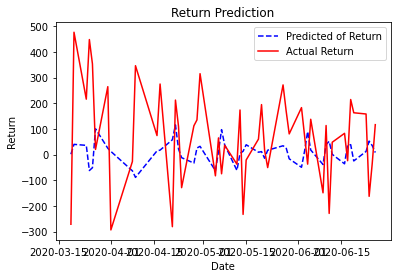

<Figure size 2160x720 with 0 Axes>

In [ ]:
plt.plot(d_index, Combined, color='blue', linestyle='dashed',label='Predicted of Return')
plt.plot(d_index, test_data['Return'].values, color='red', label='Actual Return')
plt.title('Return Prediction')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.figure(figsize=(30,10))
plt.show()
    

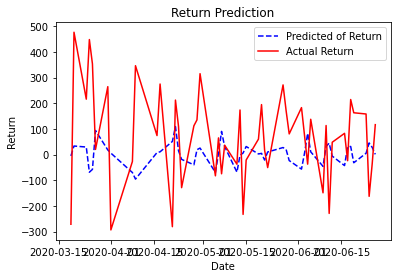

<Figure size 2160x720 with 0 Axes>

In [ ]:
plt.plot(d_index, predictions_R, color='blue', linestyle='dashed',label='Predicted of Return')
plt.plot(d_index, test_data['Return'].values, color='red', label='Actual Return')
plt.title('Return Prediction')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.figure(figsize=(30,10))
plt.show()
    

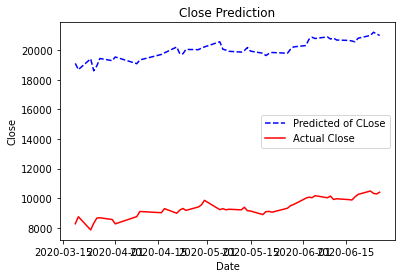

<Figure size 2160x720 with 0 Axes>

In [ ]:
plt.plot(d_index, Combined_C, color='blue', linestyle='dashed',label='Predicted of CLose')
plt.plot(d_index, test_data['close'].values, color='red', label='Actual Close')
plt.title('Close Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.figure(figsize=(30,10))
plt.show()